# ЛР 5
Виконав: Олег Басистий  

[гітхаб репо](https://github.com/n1n1n1q/SignalProcessingLabs)

In [72]:
!pip install PyRQA antropy nolds

  Using cached future-1.0.0-py3-none-any.whl.metadata (4.0 kB)

   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------------------------- 0/2 [future]
   ---------------------

In [43]:
import antropy as ant
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, filtfilt, coherence


## Завдання 1

In [2]:
def load_mat_signal(file_path):
    return np.array(loadmat(file_path)['sig'][0])

In [3]:
healthy = load_mat_signal('../lab01/data/eeg/eeg_healthy_1.mat')
sick = load_mat_signal('../lab01/data/eeg/eeg_sick_1.mat')
fs = 256

### Завдання 1.1

In [4]:
orders = [2, 3, 4, 5]
entropy_healthy = [ant.perm_entropy(healthy, order=n) for n in orders]
entropy_sick= [ant.perm_entropy(sick, order=n) for n in orders]

In [5]:
for n, h, s in zip(orders, entropy_healthy, entropy_sick):
    print(f"n={n}: Healthy={h:.4f}, Sick={s:.4f}")

n=2: Healthy=0.7909, Sick=0.9530
n=3: Healthy=1.6485, Sick=1.4851
n=4: Healthy=2.1371, Sick=1.7459
n=5: Healthy=3.0768, Sick=2.2312


### Завдання 1.2

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low, high = lowcut / nyq, highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    return filtfilt(b, a, data)

In [7]:
bands = {
    "delta": (0.5, 3),
    "theta": (4, 6),
    "alpha": (8, 13),
    "beta": (14, 40),
    "gamma": (40, fs/2 - 1)
}

In [8]:
band_entropy = {band: {"healthy": [], "patient": []} for band in bands}

for band, (low, high) in bands.items():
    eeg_h_filt = bandpass_filter(healthy, low, high, fs)
    eeg_p_filt = bandpass_filter(sick, low, high, fs)
    for n in orders:
        band_entropy[band]["healthy"].append(ant.perm_entropy(eeg_h_filt, order=n))
        band_entropy[band]["patient"].append(ant.perm_entropy(eeg_p_filt, order=n))

### Завдання 1.3

In [9]:
print("| Ритм | Порядок | Ентропія здорової людини | Ентропія хворої людини |")
print("|:--------|:-------:|:----------------|:----------------|")

for band in band_entropy.keys():
    for i, n in enumerate(orders):
        h = band_entropy[band]["healthy"][i]
        p = band_entropy[band]["patient"][i]
        print(f"| {band} | {n} | {h:.4f} | {p:.4f} |")

| Ритм | Порядок | Ентропія здорової людини | Ентропія хворої людини |
|:--------|:-------:|:----------------|:----------------|
| delta | 2 | 0.2644 | 0.1909 |
| delta | 3 | 0.2809 | 0.1989 |
| delta | 4 | 0.2973 | 0.2069 |
| delta | 5 | 0.3138 | 0.2149 |
| theta | 2 | 0.9999 | 0.9997 |
| theta | 3 | 1.2919 | 1.2723 |
| theta | 4 | 1.5816 | 1.5476 |
| theta | 5 | 1.8734 | 1.8231 |
| alpha | 2 | 0.9999 | 0.9999 |
| alpha | 3 | 1.4977 | 1.5017 |
| alpha | 4 | 1.9913 | 2.0068 |
| alpha | 5 | 2.4914 | 2.5132 |
| beta | 2 | 1.0000 | 0.9994 |
| beta | 3 | 1.9026 | 1.7426 |
| beta | 4 | 2.8404 | 2.5369 |
| beta | 5 | 3.8320 | 3.3844 |
| gamma | 2 | 1.0000 | 0.9999 |
| gamma | 3 | 2.5838 | 2.5768 |
| gamma | 4 | 4.5730 | 4.5610 |
| gamma | 5 | 6.8381 | 6.8239 |


| Ритм | Порядок | Ентропія здорової людини | Ентропія хворої людини |
|:--------|:-------:|:----------------|:----------------|
| delta | 2 | 0.2644 | 0.1909 |
| delta | 3 | 0.2809 | 0.1989 |
| delta | 4 | 0.2973 | 0.2069 |
| delta | 5 | 0.3138 | 0.2149 |
| theta | 2 | 0.9999 | 0.9997 |
| theta | 3 | 1.2919 | 1.2723 |
| theta | 4 | 1.5816 | 1.5476 |
| theta | 5 | 1.8734 | 1.8231 |
| alpha | 2 | 0.9999 | 0.9999 |
| alpha | 3 | 1.4977 | 1.5017 |
| alpha | 4 | 1.9913 | 2.0068 |
| alpha | 5 | 2.4914 | 2.5132 |
| beta | 2 | 1.0000 | 0.9994 |
| beta | 3 | 1.9026 | 1.7426 |
| beta | 4 | 2.8404 | 2.5369 |
| beta | 5 | 3.8320 | 3.3844 |
| gamma | 2 | 1.0000 | 0.9999 |
| gamma | 3 | 2.5838 | 2.5768 |
| gamma | 4 | 4.5730 | 4.5610 |
| gamma | 5 | 6.8381 | 6.8239 |

### Висновки; Аналіз

## Завдання 2

In [10]:
fs = 1000
T = 10
N = T * fs
t = t = np.arange(N) / fs

In [11]:
noise = np.random.normal(0, 1, N)

In [12]:
pulse_T = 0.1
pulse_N = int(pulse_T * fs)
pulse = np.ones(pulse_N)
pulse_start = np.random.randint(0, N - pulse_N)
pulse_end = pulse_start + pulse_N

In [13]:
impulse_signal = np.zeros(N)
impulse_signal[pulse_start:pulse_end] = pulse

In [14]:
signal = noise + impulse_signal

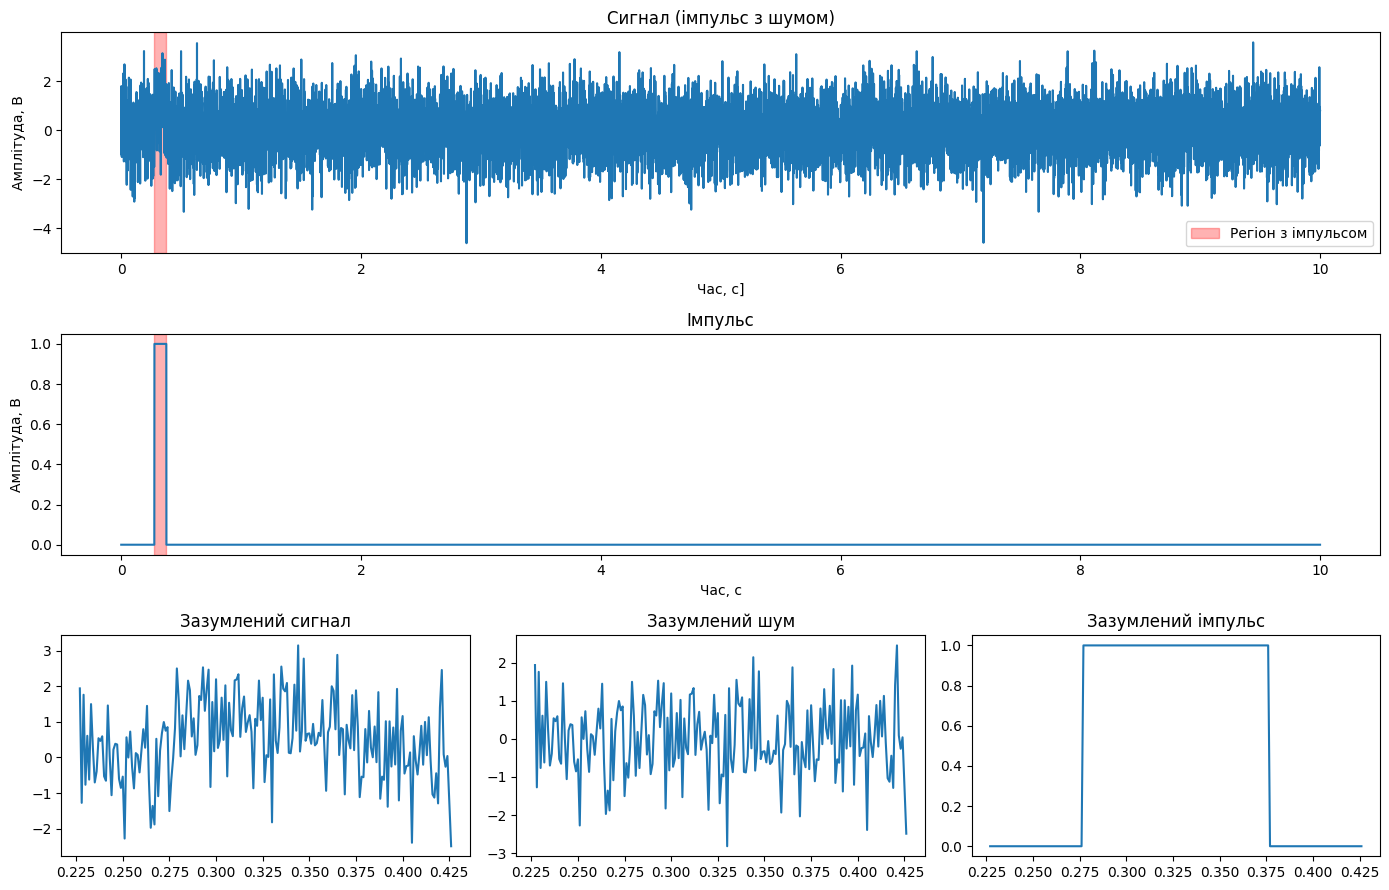

In [15]:
plt.figure(figsize=(14, 9))

ax1 = plt.subplot2grid((3, 3), (0, 0), colspan=3)
ax1.plot(t, signal)
ax1.axvspan(t[pulse_start], t[pulse_end], color='r', alpha=0.3, label='Регіон з імпульсом')
ax1.set_title("Сигнал (імпульс з шумом)")
ax1.set_xlabel("Час, с]")
ax1.set_ylabel("Амплітуда, В")
ax1.legend()

ax2 = plt.subplot2grid((3, 3), (1, 0), colspan=3)
ax2.plot(t, impulse_signal)
ax2.axvspan(t[pulse_start], t[pulse_end], color='r', alpha=0.3)
ax2.set_title("Імпульс")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

ax3 = plt.subplot2grid((3, 3), (2, 0))
ax3.plot(t[pulse_start - 50:pulse_end + 50], signal[pulse_start - 50:pulse_end + 50])
ax3.set_title("Зазумлений сигнал")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

ax4 = plt.subplot2grid((3, 3), (2, 1))
ax4.plot(t[pulse_start - 50:pulse_end + 50], noise[pulse_start - 50:pulse_end + 50])
ax4.set_title("Зазумлений шум")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

ax5 = plt.subplot2grid((3, 3), (2, 2))
ax5.plot(t[pulse_start - 50:pulse_end + 50], impulse_signal[pulse_start - 50:pulse_end + 50])
ax5.set_title("Зазумлений імпульс")
ax2.set_xlabel("Час, с")
ax2.set_ylabel("Амплітуда, В")

plt.tight_layout()
plt.show()

### Завдання 2.2

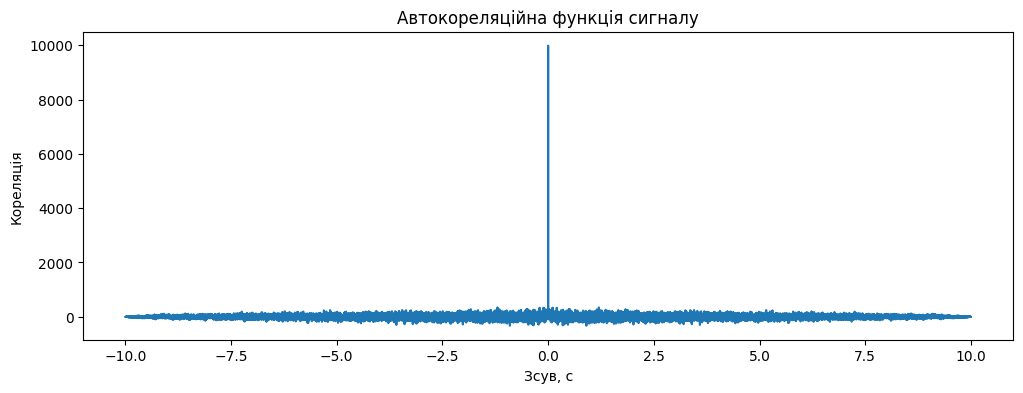

In [16]:
autocorr = np.correlate(signal, signal, mode='full')
lags = np.arange(-N + 1, N) / fs

plt.figure(figsize=(12, 4))
plt.plot(lags, autocorr)
plt.title('Автокореляційна функція сигналу')
plt.xlabel('Зсув, с')
plt.ylabel('Кореляція')
plt.show()

### Завдання 2.3

In [17]:
template = np.ones(pulse_N)
cross_corr = np.correlate(signal, template, mode='full')
lags_cross = np.arange(-len(template) + 1, len(signal)) / fs

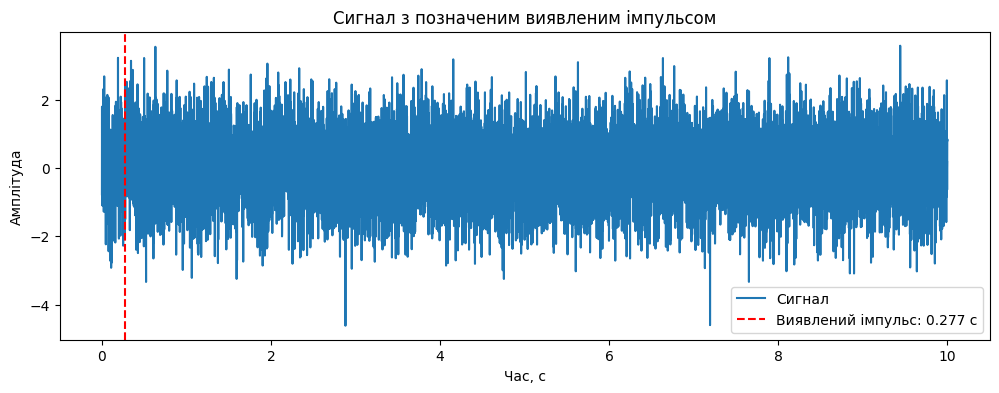

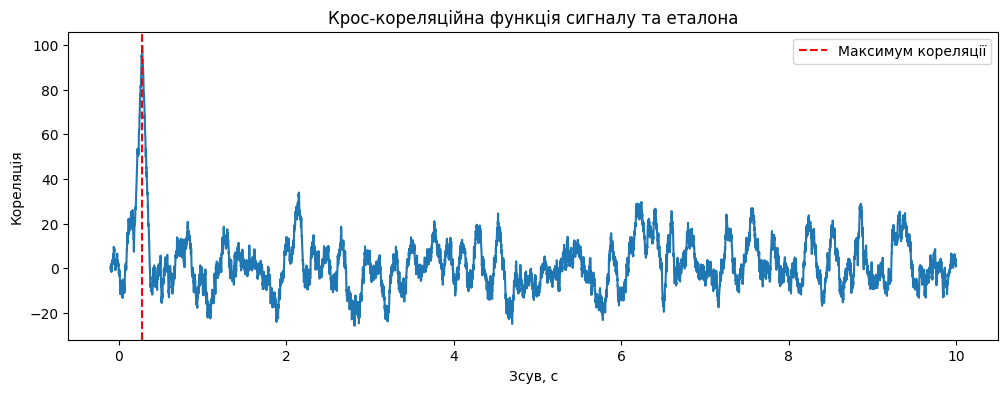

In [18]:
max_idx = np.argmax(cross_corr)
detected_time = lags_cross[max_idx]

plt.figure(figsize=(12, 4))
plt.plot(t, signal, label='Сигнал')
plt.axvline(detected_time, color='r', linestyle='--', label=f'Виявлений імпульс: {detected_time:.3f} с')
plt.title('Сигнал з позначеним виявленим імпульсом')
plt.xlabel('Час, с')
plt.ylabel('Амплітуда')
plt.legend()
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(lags_cross, cross_corr)
plt.title('Крос-кореляційна функція сигналу та еталона')
plt.xlabel('Зсув, с')
plt.ylabel('Кореляція')
plt.axvline(detected_time, color='r', linestyle='--', label='Максимум кореляції')
plt.legend()
plt.show()


In [19]:
print(f"Виявлений час появи імпульсу: {detected_time:.3f} с")

Виявлений час появи імпульсу: 0.277 с


### Завдання 2.4

In [20]:
snr_levels = [0, 5, 10]
signals_snr = {}
autocorr_snr = {}
cross_corr_snr = {}
detected_times = {}
errors = {}

true_pulse_time = t[pulse_start]

print(f"Справжнє положення імпульсу: {true_pulse_time:.3f} с")
print(f"Довжина імпульсу: {pulse_T} с")
print(f"Діапазон імпульсу: [{t[pulse_start]:.3f}, {t[pulse_end]:.3f}] с")
print("\n" + "="*60 + "\n")

Справжнє положення імпульсу: 0.277 с
Довжина імпульсу: 0.1 с
Діапазон імпульсу: [0.277, 0.377] с




In [21]:
for snr in snr_levels:
    print(f"Обробка SNR = {snr} дБ")
    
    signal_power = np.mean(impulse_signal ** 2)
    snr_linear = 10 ** (snr / 10)
    noise_power = signal_power / snr_linear
    noise = np.random.normal(0, np.sqrt(noise_power), len(signal))
    noisy_signal = signal + noise
    signals_snr[snr] = noisy_signal

    autocorr = np.correlate(noisy_signal, noisy_signal, mode='full')
    autocorr_snr[snr] = autocorr

    cross_corr = np.correlate(noisy_signal, template, mode='full')
    cross_corr_snr[snr] = cross_corr

    max_idx = np.argmax(cross_corr)
    detected_time = lags_cross[max_idx]
    detected_times[snr] = detected_time

    error = abs(detected_time - true_pulse_time)
    errors[snr] = error
    
    print(f"Виявлений час: {detected_time:.3f} с")
    print(f"Похибка: {error:.3f} с ({error*1000:.2f} мс)")
    print(f"Максимальне значення крос-кореляції: {cross_corr[max_idx]:.2f}")
    print()

Обробка SNR = 0 дБ
Виявлений час: 0.277 с
Похибка: 0.000 с (0.00 мс)
Максимальне значення крос-кореляції: 98.78

Обробка SNR = 5 дБ
Виявлений час: 0.277 с
Похибка: 0.000 с (0.00 мс)
Максимальне значення крос-кореляції: 99.52

Обробка SNR = 10 дБ
Виявлений час: 0.277 с
Похибка: 0.000 с (0.00 мс)
Максимальне значення крос-кореляції: 98.96



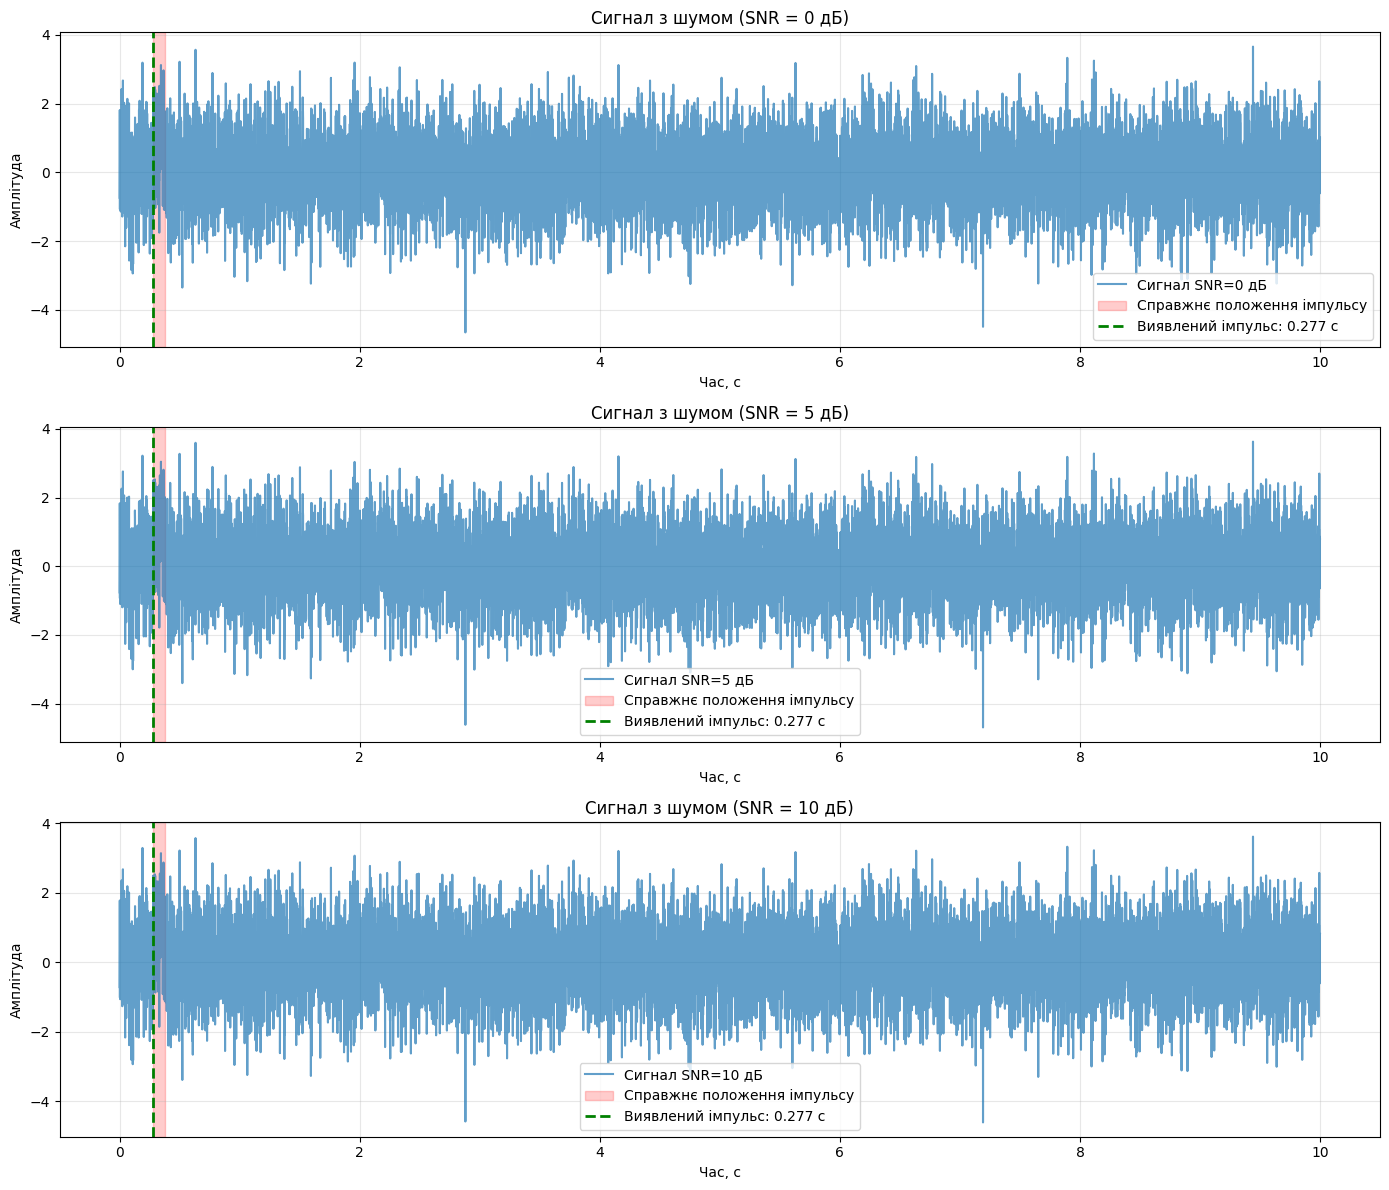

In [22]:
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(14, 4*len(snr_levels)))

for i, snr in enumerate(snr_levels):
    ax = axes[i] if len(snr_levels) > 1 else axes
    
    ax.plot(t, signals_snr[snr], label=f'Сигнал SNR={snr} дБ', alpha=0.7)
    ax.axvspan(t[pulse_start], t[pulse_end], color='r', alpha=0.2, label='Справжнє положення імпульсу')
    ax.axvline(detected_times[snr], color='g', linestyle='--', linewidth=2, 
               label=f'Виявлений імпульс: {detected_times[snr]:.3f} с')
    ax.set_title(f'Сигнал з шумом (SNR = {snr} дБ)')
    ax.set_xlabel('Час, с')
    ax.set_ylabel('Амплітуда')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

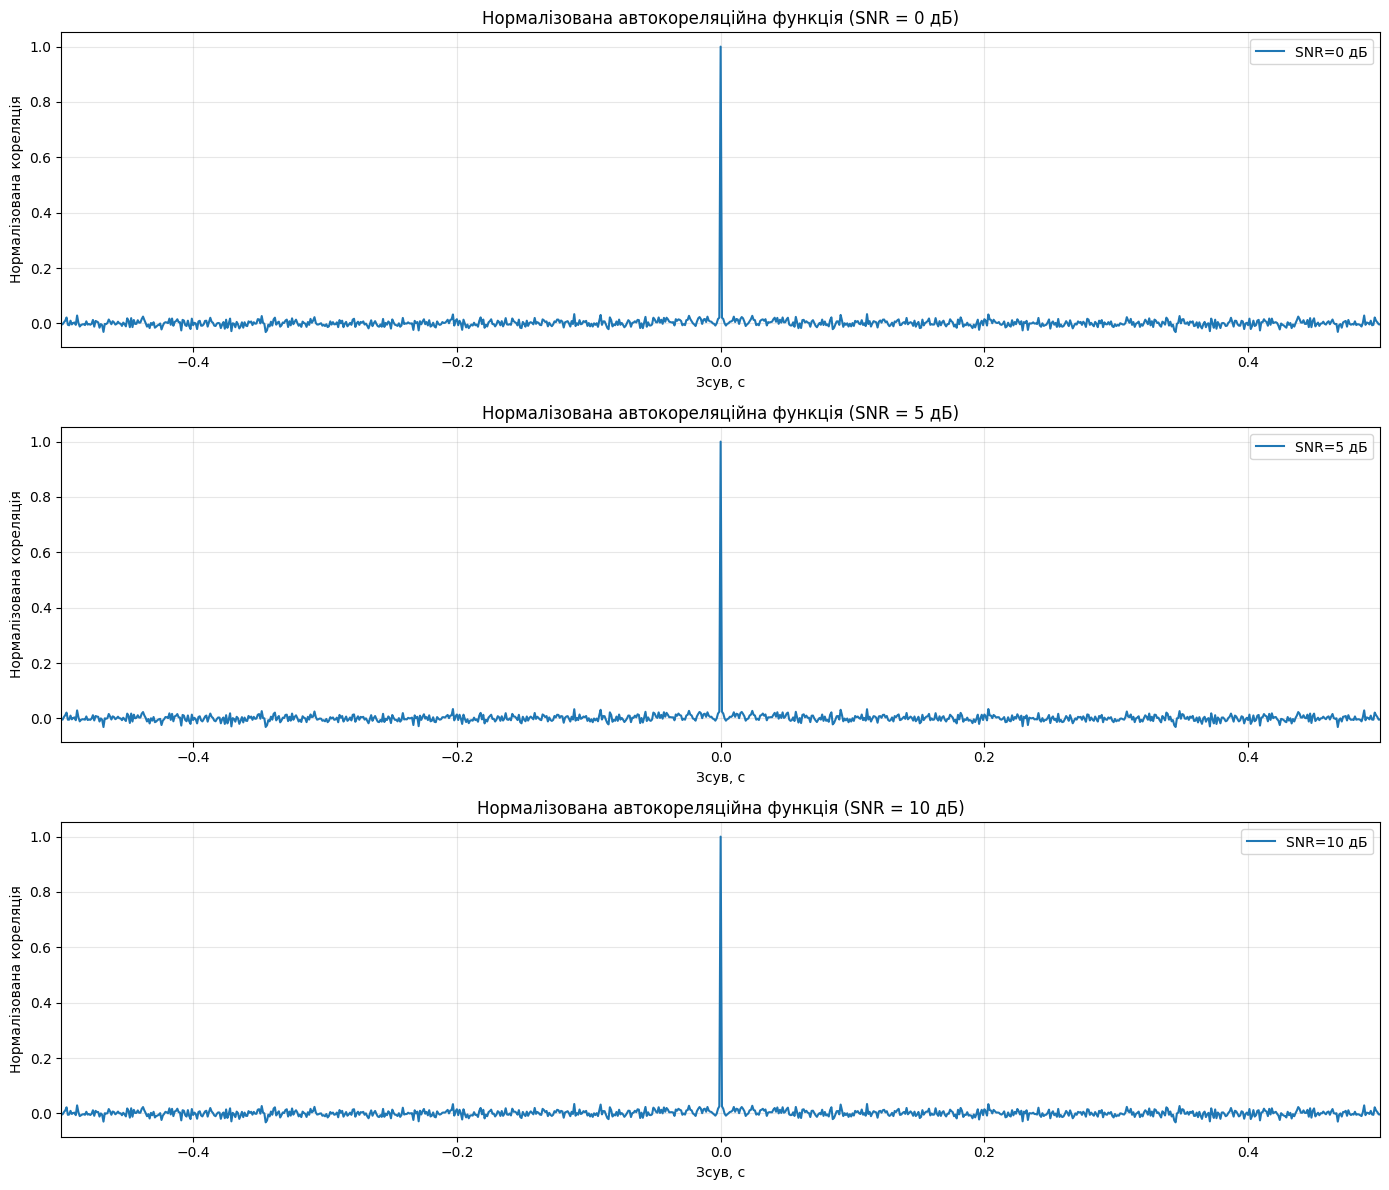

In [23]:
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(14, 4*len(snr_levels)))

for i, snr in enumerate(snr_levels):
    ax = axes[i] if len(snr_levels) > 1 else axes
    
    autocorr_norm = autocorr_snr[snr] / np.max(autocorr_snr[snr])
    ax.plot(lags, autocorr_norm, label=f'SNR={snr} дБ')
    ax.set_title(f'Нормалізована автокореляційна функція (SNR = {snr} дБ)')
    ax.set_xlabel('Зсув, с')
    ax.set_ylabel('Нормалізована кореляція')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-0.5, 0.5])

plt.tight_layout()
plt.show()

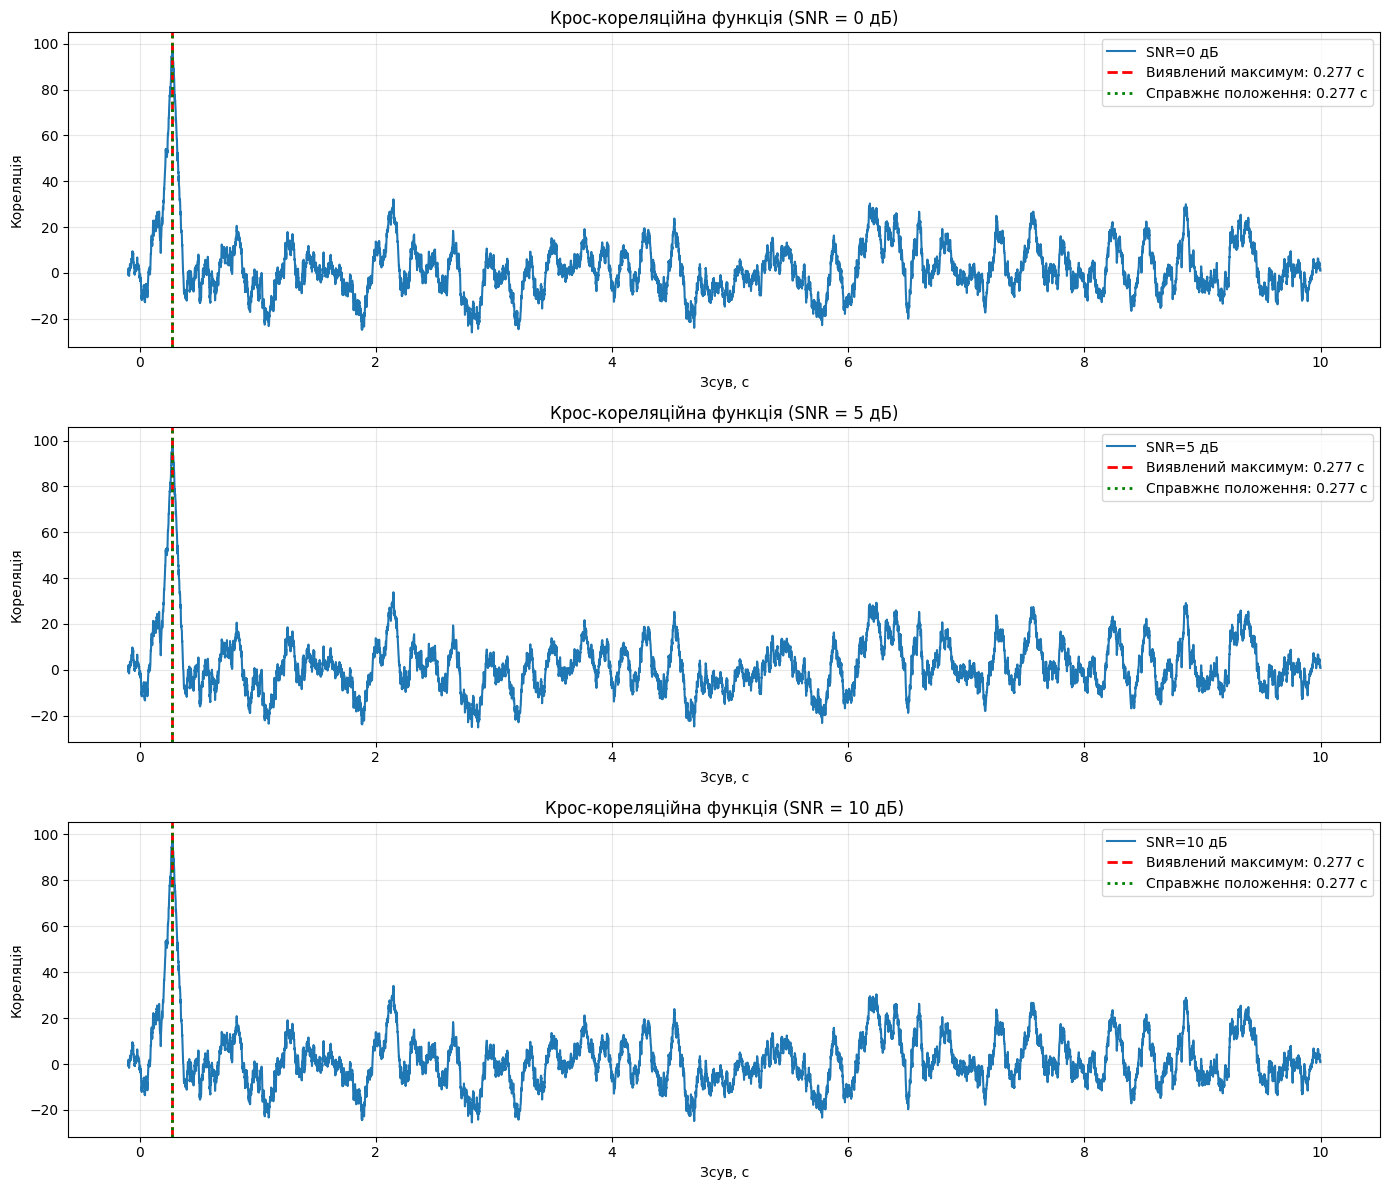

In [24]:
fig, axes = plt.subplots(len(snr_levels), 1, figsize=(14, 4*len(snr_levels)))

for i, snr in enumerate(snr_levels):
    ax = axes[i] if len(snr_levels) > 1 else axes
    
    ax.plot(lags_cross, cross_corr_snr[snr], label=f'SNR={snr} дБ')
    ax.axvline(detected_times[snr], color='r', linestyle='--', linewidth=2,
               label=f'Виявлений максимум: {detected_times[snr]:.3f} с')
    ax.axvline(true_pulse_time, color='g', linestyle=':', linewidth=2,
               label=f'Справжнє положення: {true_pulse_time:.3f} с')
    ax.set_title(f'Крос-кореляційна функція (SNR = {snr} дБ)')
    ax.set_xlabel('Зсув, с')
    ax.set_ylabel('Кореляція')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

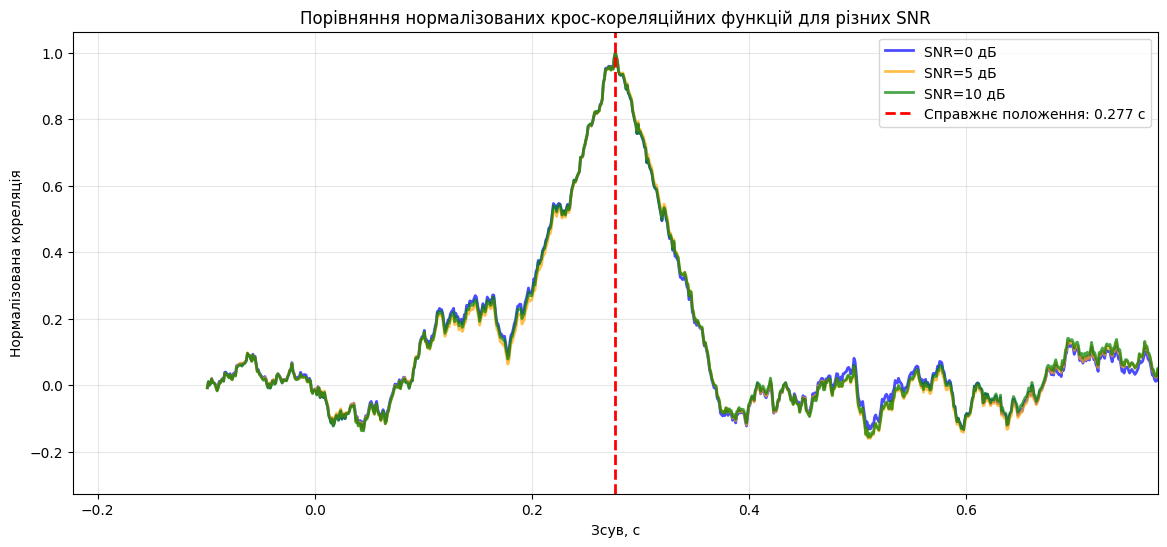

In [25]:
plt.figure(figsize=(14, 6))

colors = ['blue', 'orange', 'green']
for i, snr in enumerate(snr_levels):
    cross_corr_norm = cross_corr_snr[snr] / np.max(cross_corr_snr[snr])
    plt.plot(lags_cross, cross_corr_norm, label=f'SNR={snr} дБ', 
             alpha=0.7, linewidth=2, color=colors[i])

plt.axvline(true_pulse_time, color='red', linestyle='--', linewidth=2,
            label=f'Справжнє положення: {true_pulse_time:.3f} с')
plt.title('Порівняння нормалізованих крос-кореляційних функцій для різних SNR')
plt.xlabel('Зсув, с')
plt.ylabel('Нормалізована кореляція')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim([true_pulse_time - 0.5, true_pulse_time + 0.5])
plt.show()

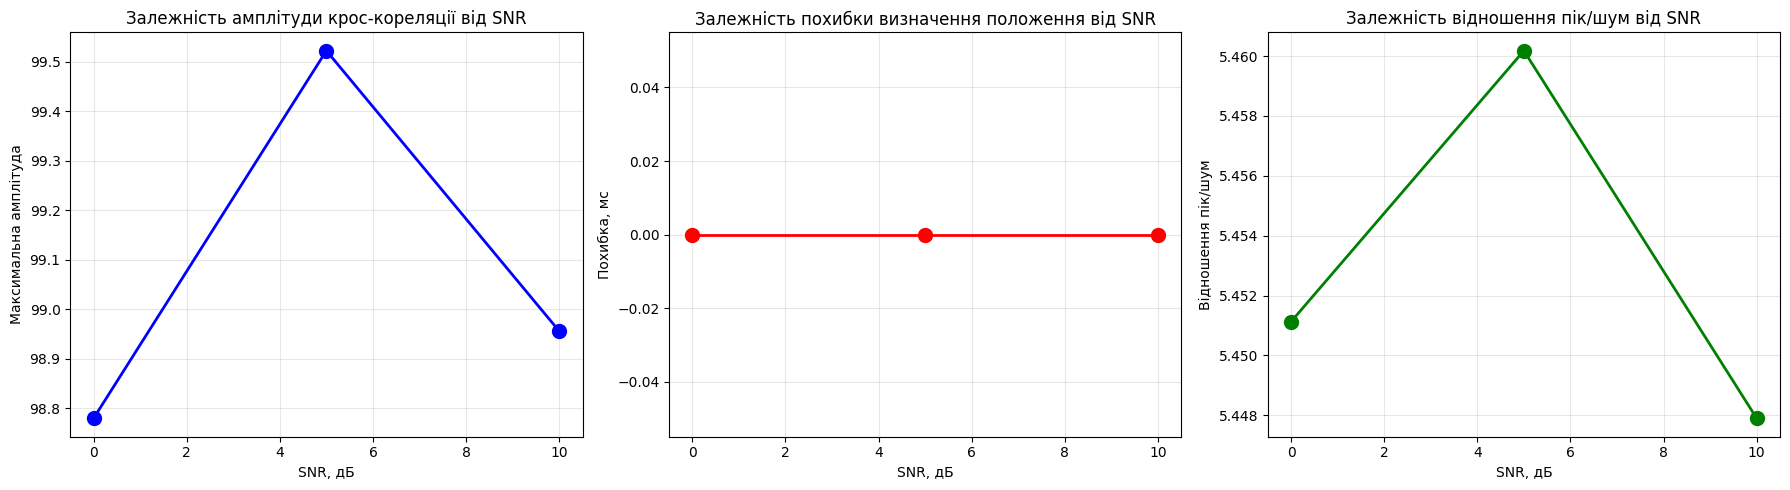

In [28]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

max_amplitudes = [np.max(cross_corr_snr[snr]) for snr in snr_levels]
axes[0].plot(snr_levels, max_amplitudes, 'o-', linewidth=2, markersize=10, color='blue')
axes[0].set_xlabel('SNR, дБ')
axes[0].set_ylabel('Максимальна амплітуда')
axes[0].set_title('Залежність амплітуди крос-кореляції від SNR')
axes[0].grid(True, alpha=0.3)

error_values = [errors[snr] * 1000 for snr in snr_levels]  # в мс
axes[1].plot(snr_levels, error_values, 'o-', linewidth=2, markersize=10, color='red')
axes[1].set_xlabel('SNR, дБ')
axes[1].set_ylabel('Похибка, мс')
axes[1].set_title('Залежність похибки визначення положення від SNR')
axes[1].grid(True, alpha=0.3)

peak_snr_values = []
for snr in snr_levels:
    max_amplitude = np.max(cross_corr_snr[snr])
    noise_level = np.std(cross_corr_snr[snr][:len(cross_corr_snr[snr])//4])
    peak_snr_values.append(max_amplitude / noise_level)

axes[2].plot(snr_levels, peak_snr_values, 'o-', linewidth=2, markersize=10, color='green')
axes[2].set_xlabel('SNR, дБ')
axes[2].set_ylabel('Відношення пік/шум')
axes[2].set_title('Залежність відношення пік/шум від SNR')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Завдання 2.5

In [29]:
print("| Значення SNR (дБ) | Амплітуда максимального піку кореляції | Знайдене положення імпульсу (мс) | Похибка визначення положення (мс) |")
print("|:-----------------:|:--------------------------------------:|:--------------------------------:|:---------------------------------:|")

for snr in snr_levels:
    max_amplitude = np.max(cross_corr_snr[snr])
    detected_position_ms = detected_times[snr] * 1000
    error_ms = errors[snr] * 1000
    
    print(f"| {snr:^17} | {max_amplitude:^38.2f} | {detected_position_ms:^32.2f} | {error_ms:^33.2f} |")

| Значення SNR (дБ) | Амплітуда максимального піку кореляції | Знайдене положення імпульсу (мс) | Похибка визначення положення (мс) |
|:-----------------:|:--------------------------------------:|:--------------------------------:|:---------------------------------:|
|         0         |                 98.78                  |              277.00              |               0.00                |
|         5         |                 99.52                  |              277.00              |               0.00                |
|        10         |                 98.96                  |              277.00              |               0.00                |


| Значення SNR (дБ) | Амплітуда максимального піку кореляції | Знайдене положення імпульсу (мс) | Похибка визначення положення (мс) |
|:-----------------:|:--------------------------------------:|:--------------------------------:|:---------------------------------:|
|         0         |                 98.78                  |              277.00              |               0.00                |
|         5         |                 99.52                  |              277.00              |               0.00                |
|        10         |                 98.96                  |              277.00              |               0.00                |

## Завдання 3

### Завдання 3.1

In [31]:
acc_fs = 100
standing_accel = pd.read_csv("../lab01/data/imu/acc_standing.csv")
walking_accel = pd.read_csv("../lab01/data/imu/acc_walking.csv")
running_accel = pd.read_csv("../lab01/data/imu/acc_running.csv")

In [38]:
standing_accel.head()

,time,ax,ay,az,atotal
0,0.00,0.09,0.45,-0.86,0.98
1,0.01,0.32,0.36,-0.37,0.60
2,0.02,0.51,0.51,0.50,0.87
3,0.03,0.13,0.43,1.06,1.15
4,0.04,0.07,0.18,1.44,1.45


In [34]:
time_ranges = {
    "standing": (3, 60),
    "walking": (3, 27),
    "running": (3, 27)
}

lowcut = 0.3
highcut = 20
filter_order = 4

In [39]:
def prepare_accel_data(df, start_sec, end_sec, fs, lowcut, highcut, order=4):
    start_idx = int(start_sec * fs)
    end_idx = int(end_sec * fs)
    x = df['ax'].values[start_idx:end_idx]
    y = df['ay'].values[start_idx:end_idx]
    z = df['az'].values[start_idx:end_idx]
    t = np.arange(len(x)) / fs
    x_filt = bandpass_filter(x, lowcut, highcut, fs, order)
    y_filt = bandpass_filter(y, lowcut, highcut, fs, order)
    z_filt = bandpass_filter(z, lowcut, highcut, fs, order)
    
    return {
        'X': x_filt,
        'Y': y_filt,
        'Z': z_filt,
        't': t,
        'X_raw': x,
        'Y_raw': y,
        'Z_raw': z
    }

In [40]:
standing_data = prepare_accel_data(
    standing_accel, 
    time_ranges["standing"][0], 
    time_ranges["standing"][1], 
    acc_fs, 
    lowcut, 
    highcut, 
    filter_order
)

walking_data = prepare_accel_data(
    walking_accel, 
    time_ranges["walking"][0], 
    time_ranges["walking"][1], 
    acc_fs, 
    lowcut, 
    highcut, 
    filter_order
)

running_data = prepare_accel_data(
    running_accel, 
    time_ranges["running"][0], 
    time_ranges["running"][1], 
    acc_fs, 
    lowcut, 
    highcut, 
    filter_order
)

print(f"Standing: {len(standing_data['t'])} відліків, тривалість: {standing_data['t'][-1]:.2f} с")
print(f"Walking: {len(walking_data['t'])} відліків, тривалість: {walking_data['t'][-1]:.2f} с")
print(f"Running: {len(running_data['t'])} відліків, тривалість: {running_data['t'][-1]:.2f} с")

Standing: 5700 відліків, тривалість: 56.99 с
Walking: 2400 відліків, тривалість: 23.99 с
Running: 2400 відліків, тривалість: 23.99 с


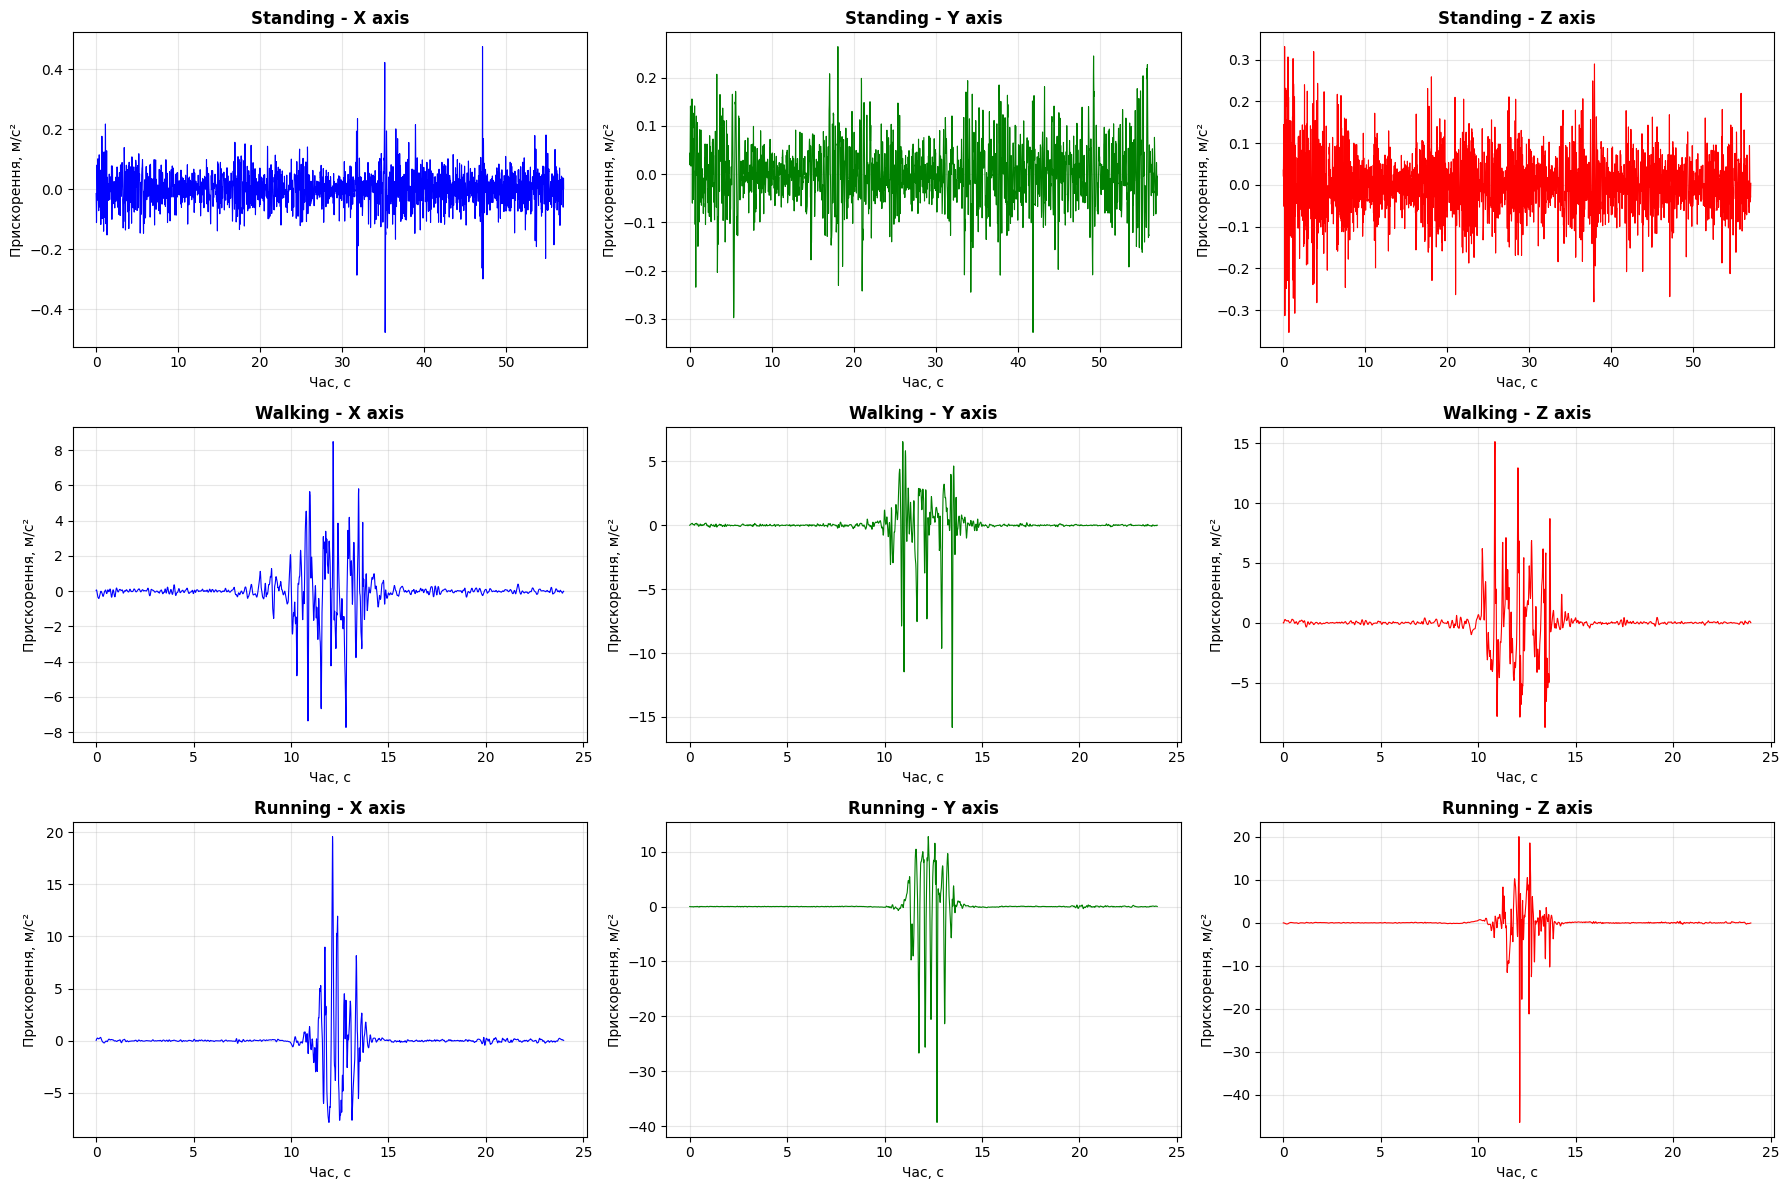

In [41]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))


axes[0, 0].plot(standing_data['t'], standing_data['X'], 'b-', linewidth=0.8)
axes[0, 0].set_title('Standing - X axis', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Час, с')
axes[0, 0].set_ylabel('Прискорення, м/c^2')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(standing_data['t'], standing_data['Y'], 'g-', linewidth=0.8)
axes[0, 1].set_title('Standing - Y axis', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Час, с')
axes[0, 1].set_ylabel('Прискорення, м/c^2')
axes[0, 1].grid(True, alpha=0.3)

axes[0, 2].plot(standing_data['t'], standing_data['Z'], 'r-', linewidth=0.8)
axes[0, 2].set_title('Standing - Z axis', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Час, с')
axes[0, 2].set_ylabel('Прискорення, м/c^2')
axes[0, 2].grid(True, alpha=0.3)

axes[1, 0].plot(walking_data['t'], walking_data['X'], 'b-', linewidth=0.8)
axes[1, 0].set_title('Walking - X axis', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Час, с')
axes[1, 0].set_ylabel('Прискорення, м/c^2')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(walking_data['t'], walking_data['Y'], 'g-', linewidth=0.8)
axes[1, 1].set_title('Walking - Y axis', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Час, с')
axes[1, 1].set_ylabel('Прискорення, м/c^2')
axes[1, 1].grid(True, alpha=0.3)

axes[1, 2].plot(walking_data['t'], walking_data['Z'], 'r-', linewidth=0.8)
axes[1, 2].set_title('Walking - Z axis', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Час, с')
axes[1, 2].set_ylabel('Прискорення, м/c^2')
axes[1, 2].grid(True, alpha=0.3)

axes[2, 0].plot(running_data['t'], running_data['X'], 'b-', linewidth=0.8)
axes[2, 0].set_title('Running - X axis', fontsize=12, fontweight='bold')
axes[2, 0].set_xlabel('Час, с')
axes[2, 0].set_ylabel('Прискорення, м/c^2')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(running_data['t'], running_data['Y'], 'g-', linewidth=0.8)
axes[2, 1].set_title('Running - Y axis', fontsize=12, fontweight='bold')
axes[2, 1].set_xlabel('Час, с')
axes[2, 1].set_ylabel('Прискорення, м/c^2')
axes[2, 1].grid(True, alpha=0.3)

axes[2, 2].plot(running_data['t'], running_data['Z'], 'r-', linewidth=0.8)
axes[2, 2].set_title('Running - Z axis', fontsize=12, fontweight='bold')
axes[2, 2].set_xlabel('Час, с')
axes[2, 2].set_ylabel('Прискорення, м/c^2')
axes[2, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

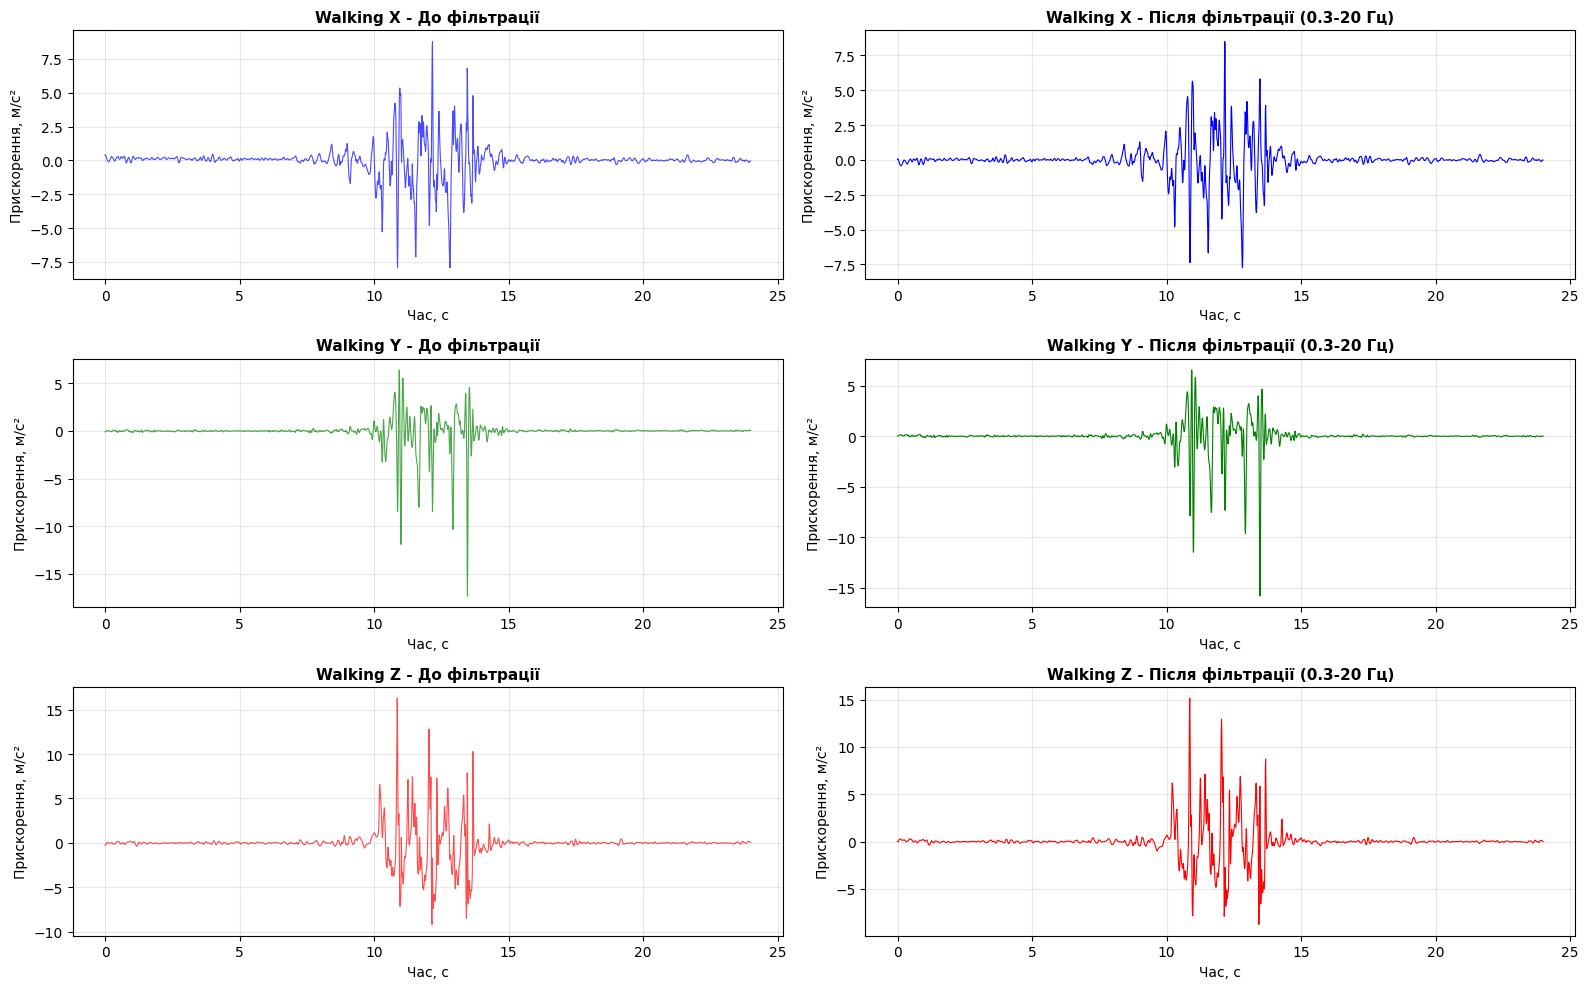

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(16, 10))

axes[0, 0].plot(walking_data['t'], walking_data['X_raw'], 'b-', linewidth=0.8, alpha=0.7)
axes[0, 0].set_title('Walking X - До фільтрації', fontsize=11, fontweight='bold')
axes[0, 0].set_xlabel('Час, с')
axes[0, 0].set_ylabel('Прискорення, м/c^2')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].plot(walking_data['t'], walking_data['X'], 'b-', linewidth=0.8)
axes[0, 1].set_title('Walking X - Після фільтрації (0.3-20 Гц)', fontsize=11, fontweight='bold')
axes[0, 1].set_xlabel('Час, с')
axes[0, 1].set_ylabel('Прискорення, м/c^2')
axes[0, 1].grid(True, alpha=0.3)

axes[1, 0].plot(walking_data['t'], walking_data['Y_raw'], 'g-', linewidth=0.8, alpha=0.7)
axes[1, 0].set_title('Walking Y - До фільтрації', fontsize=11, fontweight='bold')
axes[1, 0].set_xlabel('Час, с')
axes[1, 0].set_ylabel('Прискорення, м/c^2')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(walking_data['t'], walking_data['Y'], 'g-', linewidth=0.8)
axes[1, 1].set_title('Walking Y - Після фільтрації (0.3-20 Гц)', fontsize=11, fontweight='bold')
axes[1, 1].set_xlabel('Час, с')
axes[1, 1].set_ylabel('Прискорення, м/c^2')
axes[1, 1].grid(True, alpha=0.3)

axes[2, 0].plot(walking_data['t'], walking_data['Z_raw'], 'r-', linewidth=0.8, alpha=0.7)
axes[2, 0].set_title('Walking Z - До фільтрації', fontsize=11, fontweight='bold')
axes[2, 0].set_xlabel('Час, с')
axes[2, 0].set_ylabel('Прискорення, м/c^2')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].plot(walking_data['t'], walking_data['Z'], 'r-', linewidth=0.8)
axes[2, 1].set_title('Walking Z - Після фільтрації (0.3-20 Гц)', fontsize=11, fontweight='bold')
axes[2, 1].set_xlabel('Час, с')
axes[2, 1].set_ylabel('Прискорення, м/c^2')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Завдання 3.2

### Завдання 3.2

In [44]:
segment_duration = 4
nperseg = int(segment_duration * acc_fs) 
noverlap = nperseg // 2

In [45]:
def compute_coherence_pairs(data, fs, nperseg, noverlap):
    results = {}
    pairs = [('X', 'Y'), ('X', 'Z'), ('Y', 'Z')]
    
    for pair in pairs:
        axis1, axis2 = pair

        f, Cxy = coherence(
            data[axis1], 
            data[axis2], 
            fs=fs, 
            nperseg=nperseg, 
            noverlap=noverlap
        )

        max_idx = np.argmax(Cxy)
        max_freq = f[max_idx]
        max_coh = Cxy[max_idx]
        
        results[f"{axis1}-{axis2}"] = {
            'freq': f,
            'coherence': Cxy,
            'max_freq': max_freq,
            'max_coherence': max_coh
        }
    
    return results

In [46]:
standing_coherence = compute_coherence_pairs(standing_data, acc_fs, nperseg, noverlap)
walking_coherence = compute_coherence_pairs(walking_data, acc_fs, nperseg, noverlap)
running_coherence = compute_coherence_pairs(running_data, acc_fs, nperseg, noverlap)

### Завдання 3.3

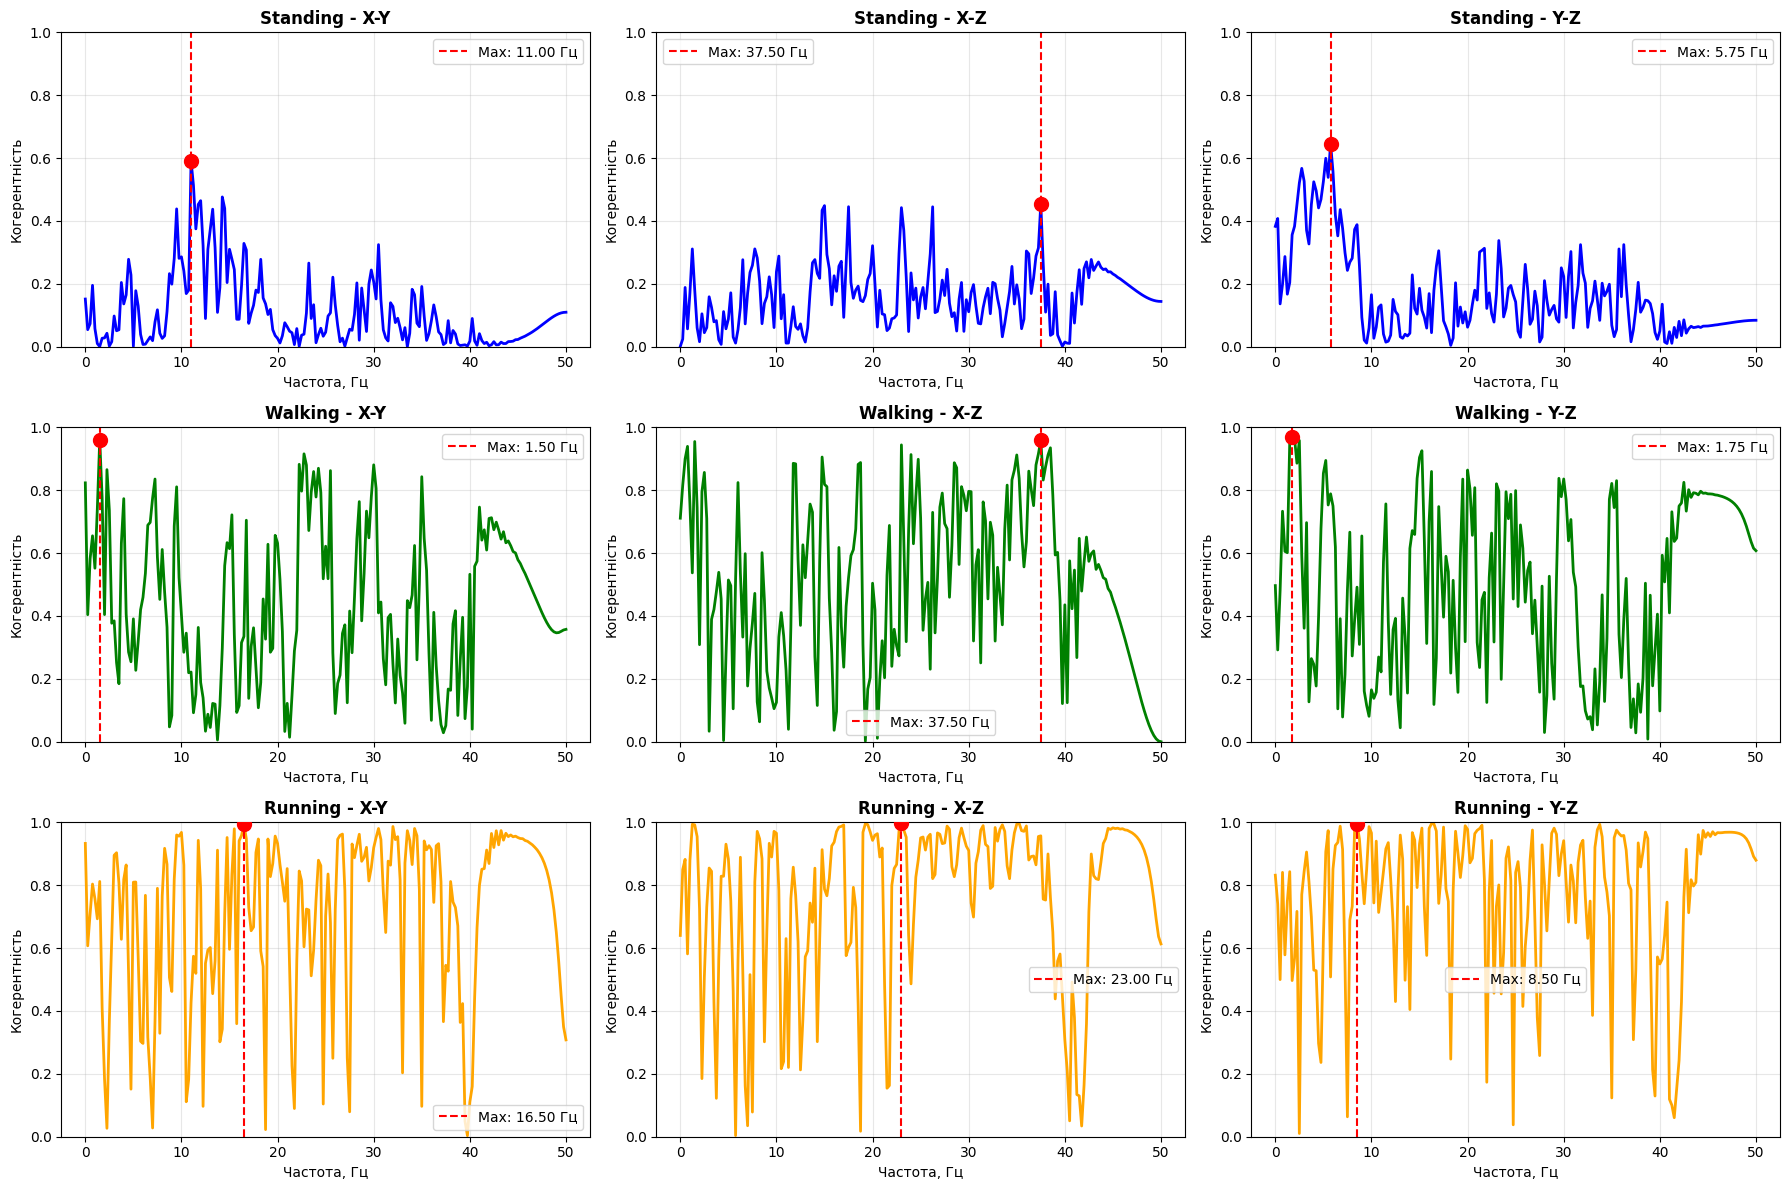

In [47]:
fig, axes = plt.subplots(3, 3, figsize=(18, 12))

for i, pair in enumerate(['X-Y', 'X-Z', 'Y-Z']):
    ax = axes[0, i]
    coh_data = standing_coherence[pair]
    ax.plot(coh_data['freq'], coh_data['coherence'], 'b-', linewidth=2)
    ax.axvline(coh_data['max_freq'], color='r', linestyle='--', linewidth=1.5,
               label=f"Max: {coh_data['max_freq']:.2f} Гц")
    ax.scatter([coh_data['max_freq']], [coh_data['max_coherence']], 
               color='r', s=100, zorder=5)
    ax.set_title(f'Standing - {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])

for i, pair in enumerate(['X-Y', 'X-Z', 'Y-Z']):
    ax = axes[1, i]
    coh_data = walking_coherence[pair]
    ax.plot(coh_data['freq'], coh_data['coherence'], 'g-', linewidth=2)
    ax.axvline(coh_data['max_freq'], color='r', linestyle='--', linewidth=1.5,
               label=f"Max: {coh_data['max_freq']:.2f} Гц")
    ax.scatter([coh_data['max_freq']], [coh_data['max_coherence']], 
               color='r', s=100, zorder=5)
    ax.set_title(f'Walking - {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])

for i, pair in enumerate(['X-Y', 'X-Z', 'Y-Z']):
    ax = axes[2, i]
    coh_data = running_coherence[pair]
    ax.plot(coh_data['freq'], coh_data['coherence'], 'orange', linewidth=2)
    ax.axvline(coh_data['max_freq'], color='r', linestyle='--', linewidth=1.5,
               label=f"Max: {coh_data['max_freq']:.2f} Гц")
    ax.scatter([coh_data['max_freq']], [coh_data['max_coherence']], 
               color='r', s=100, zorder=5)
    ax.set_title(f'Running - {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()

### Завдання 3.4

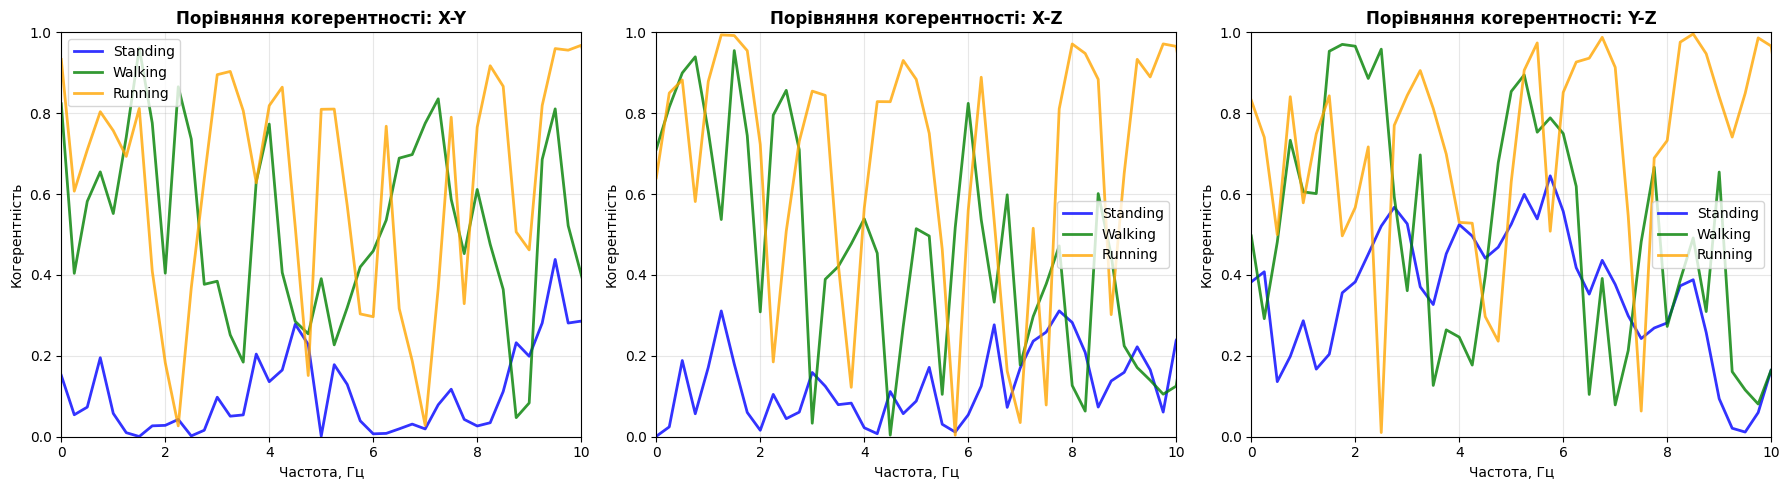

In [48]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

pairs = ['X-Y', 'X-Z', 'Y-Z']
colors = {'Standing': 'blue', 'Walking': 'green', 'Running': 'orange'}

for i, pair in enumerate(pairs):
    ax = axes[i]
    
    ax.plot(standing_coherence[pair]['freq'], 
            standing_coherence[pair]['coherence'], 
            color=colors['Standing'], linewidth=2, label='Standing', alpha=0.8)

    ax.plot(walking_coherence[pair]['freq'], 
            walking_coherence[pair]['coherence'], 
            color=colors['Walking'], linewidth=2, label='Walking', alpha=0.8)
 
    ax.plot(running_coherence[pair]['freq'], 
            running_coherence[pair]['coherence'], 
            color=colors['Running'], linewidth=2, label='Running', alpha=0.8)
    
    ax.set_title(f'Порівняння когерентності: {pair}', fontsize=12, fontweight='bold')
    ax.set_xlabel('Частота, Гц')
    ax.set_ylabel('Когерентність')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_ylim([0, 1])
    ax.set_xlim([0, 10])

plt.tight_layout()
plt.show()

## Завдання 4

### Завдання 4.1

In [55]:
signal_for_rqa = healthy
fs_rqa = 256

max_lag = len(signal_for_rqa) // 2 
autocorr_rqa = np.correlate(signal_for_rqa - np.mean(signal_for_rqa), 
                            signal_for_rqa - np.mean(signal_for_rqa), 
                            mode='full')
autocorr_rqa = autocorr_rqa[len(autocorr_rqa)//2:]

lags_rqa = np.arange(len(autocorr_rqa))

In [56]:
from scipy.signal import argrelextrema

local_minima = argrelextrema(autocorr_rqa, np.less, order=5)[0]
local_minima = local_minima[local_minima > 1]

zero_crossings = np.where(np.diff(np.sign(autocorr_rqa)))[0]
delay = zero_crossings[0]

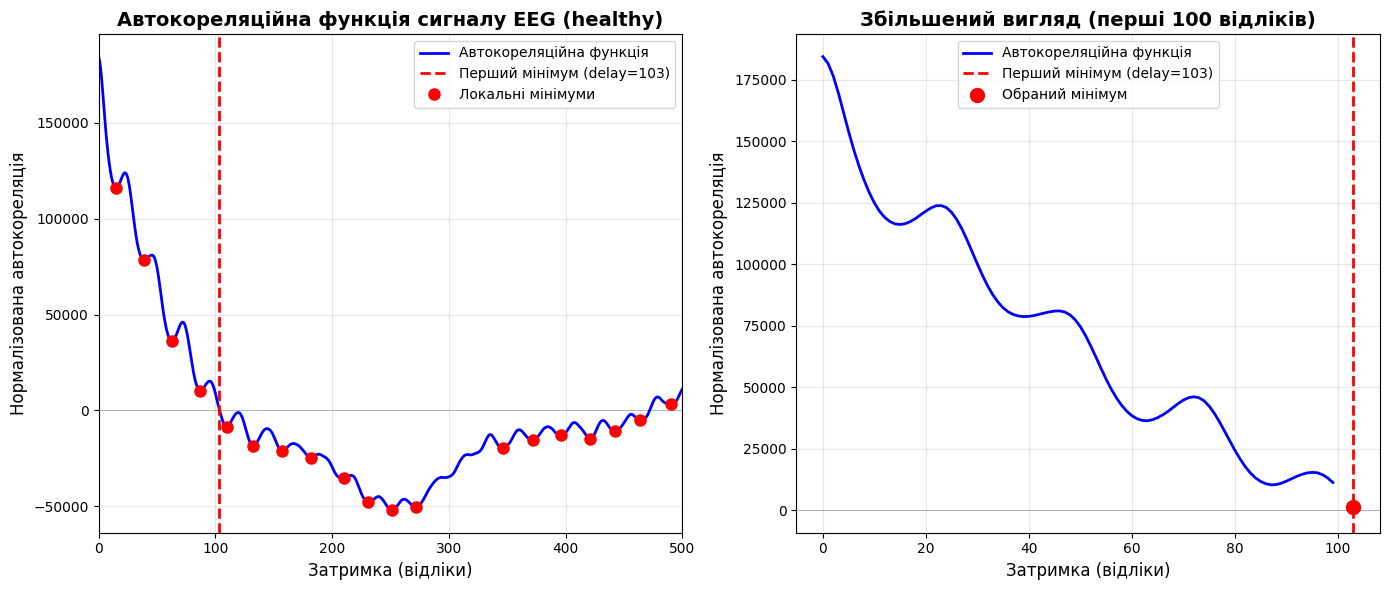

In [57]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(lags_rqa, autocorr_rqa, 'b-', linewidth=2, label='Автокореляційна функція')
plt.axvline(x=delay, color='r', linestyle='--', linewidth=2, label=f'Перший мінімум (delay={delay})')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
if len(local_minima) > 0:
    plt.plot(local_minima, autocorr_rqa[local_minima], 'ro', markersize=8, label='Локальні мінімуми')
plt.xlabel('Затримка (відліки)', fontsize=12)
plt.ylabel('Нормалізована автокореляція', fontsize=12)
plt.title('Автокореляційна функція сигналу EEG (healthy)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim([0, min(500, len(autocorr_rqa))])

plt.subplot(1, 2, 2)
zoom_range = min(100, delay * 3)
plt.plot(lags_rqa[:zoom_range], autocorr_rqa[:zoom_range], 'b-', linewidth=2, label='Автокореляційна функція')
plt.axvline(x=delay, color='r', linestyle='--', linewidth=2, label=f'Перший мінімум (delay={delay})')
plt.axhline(y=0, color='k', linestyle='-', linewidth=0.5, alpha=0.3)
if len(local_minima) > 0 and local_minima[0] < zoom_range:
    plt.plot(delay, autocorr_rqa[delay], 'ro', markersize=10, label='Обраний мінімум')
plt.xlabel('Затримка (відліки)', fontsize=12)
plt.ylabel('Нормалізована автокореляція', fontsize=12)
plt.title(f'Збільшений вигляд (перші {zoom_range} відліків)', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

### Завдання 4.2 та 4.3

In [58]:
from pyrqa.time_series import TimeSeries
from pyrqa.settings import Settings
from pyrqa.analysis_type import Classic
from pyrqa.neighbourhood import FixedRadius
from pyrqa.metric import EuclideanMetric
from pyrqa.computation import RQAComputation
from pyrqa.computation import RPComputation
from pyrqa.image_generator import ImageGenerator

In [60]:
signals_dict = {
    'Healthy EEG': healthy,
    'Sick EEG': sick
}

embedding_dimensions = [3, 10]
time_delay = delay 

In [ ]:
def estimate_threshold(signal, embedding_dim, delay, percentile=10):
    time_series = TimeSeries(signal, embedding_dimension=embedding_dim, time_delay=delay)
    
    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(0.01),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    computation = RPComputation.create(settings, verbose=False)
    result = computation.run()
    distance_matrix = result.recurrence_matrix_reverse
    
    distances = distance_matrix[np.triu_indices_from(distance_matrix, k=1)]
    distances = distances[distances > 0]
    
    threshold = np.percentile(distances, percentile)
    
    return threshold


In [66]:
def perform_rqa_analysis(signal, embedding_dim, delay, threshold):
    signal_norm = (signal - np.mean(signal)) / np.std(signal)
    max_length = 2000
    if len(signal_norm) > max_length:
        signal_norm = signal_norm[:max_length]

    time_series = TimeSeries(signal_norm, 
                            embedding_dimension=embedding_dim, 
                            time_delay=delay)

    settings = Settings(
        time_series,
        analysis_type=Classic,
        neighbourhood=FixedRadius(threshold),
        similarity_measure=EuclideanMetric,
        theiler_corrector=1
    )

    computation = RQAComputation.create(settings, verbose=False)
    result = computation.run()

    rp_computation = RPComputation.create(settings, verbose=False)
    rp_result = rp_computation.run()

    metrics = {
        'Recurrence Rate (RR)': result.recurrence_rate,
        'Determinism (DET)': result.determinism,
        'Lmax': result.longest_diagonal_line,
        'Entropy': result.entropy_diagonal_lines,
        'Laminarity (LAM)': result.laminarity,
        'Trapping Time (TT)': result.trapping_time
    }
    
    return metrics, rp_result.recurrence_matrix_reverse

In [67]:

embedding_dimensions = [3, 10]
time_delay = delay

signals_for_rqa = {
    'Healthy EEG': healthy[:3000],
    'Sick EEG': sick[:3000]
}

thresholds = {
    3: 0.5,
    10: 0.8
}


In [ ]:
results = {}

for signal_name, signal in signals_for_rqa.items():
    results[signal_name] = {}
    
    for emb_dim in embedding_dimensions:
        threshold = thresholds[emb_dim]
        print(f"\n{signal_name}, embedding dimension = {emb_dim}, threshold = {threshold}")

        metrics, recurrence_matrix = perform_rqa_analysis(signal, emb_dim, time_delay, threshold)
        
        results[signal_name][emb_dim] = {
            'metrics': metrics,
            'recurrence_matrix': recurrence_matrix,
            'threshold': threshold
        }
        
        print(f"  Recurrence Rate: {metrics['Recurrence Rate (RR)']:.4f}")
        print(f"  Determinism: {metrics['Determinism (DET)']:.4f}")
        print(f"  Lmax: {metrics['Lmax']}")
        print(f"  Entropy: {metrics['Entropy']:.4f}")
        print(f"  Laminarity: {metrics['Laminarity (LAM)']:.4f}")
        print(f"  Trapping Time: {metrics['Trapping Time (TT)']:.4f}")


Обробка: Healthy EEG, embedding dimension = 3, threshold = 0.5


c:\Users\basys\miniforge3\Lib\site-packages\pyopencl\__init__.py:570: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  lambda: self._prg.build(options_bytes, devices),


  Recurrence Rate: 0.0249
  Determinism: 0.7952
  Lmax: 170
  Entropy: 1.3993
  Laminarity: 0.9032
  Trapping Time: 3.8915

Обробка: Healthy EEG, embedding dimension = 10, threshold = 0.8
  Recurrence Rate: 0.0039
  Determinism: 0.9471
  Lmax: 338
  Entropy: 1.7558
  Laminarity: 0.9973
  Trapping Time: 4.1574

Обробка: Sick EEG, embedding dimension = 3, threshold = 0.5
  Recurrence Rate: 0.0039
  Determinism: 0.9471
  Lmax: 338
  Entropy: 1.7558
  Laminarity: 0.9973
  Trapping Time: 4.1574

Обробка: Sick EEG, embedding dimension = 3, threshold = 0.5
  Recurrence Rate: 0.0319
  Determinism: 0.9801
  Lmax: 1793
  Entropy: 2.5296
  Laminarity: 0.9908
  Trapping Time: 7.9705

Обробка: Sick EEG, embedding dimension = 10, threshold = 0.8
  Recurrence Rate: 0.0068
  Determinism: 0.9902
  Lmax: 1072
  Entropy: 2.9917
  Laminarity: 0.9999
  Trapping Time: 7.2289
  Recurrence Rate: 0.0319
  Determinism: 0.9801
  Lmax: 1793
  Entropy: 2.5296
  Laminarity: 0.9908
  Trapping Time: 7.9705

Обробка: 

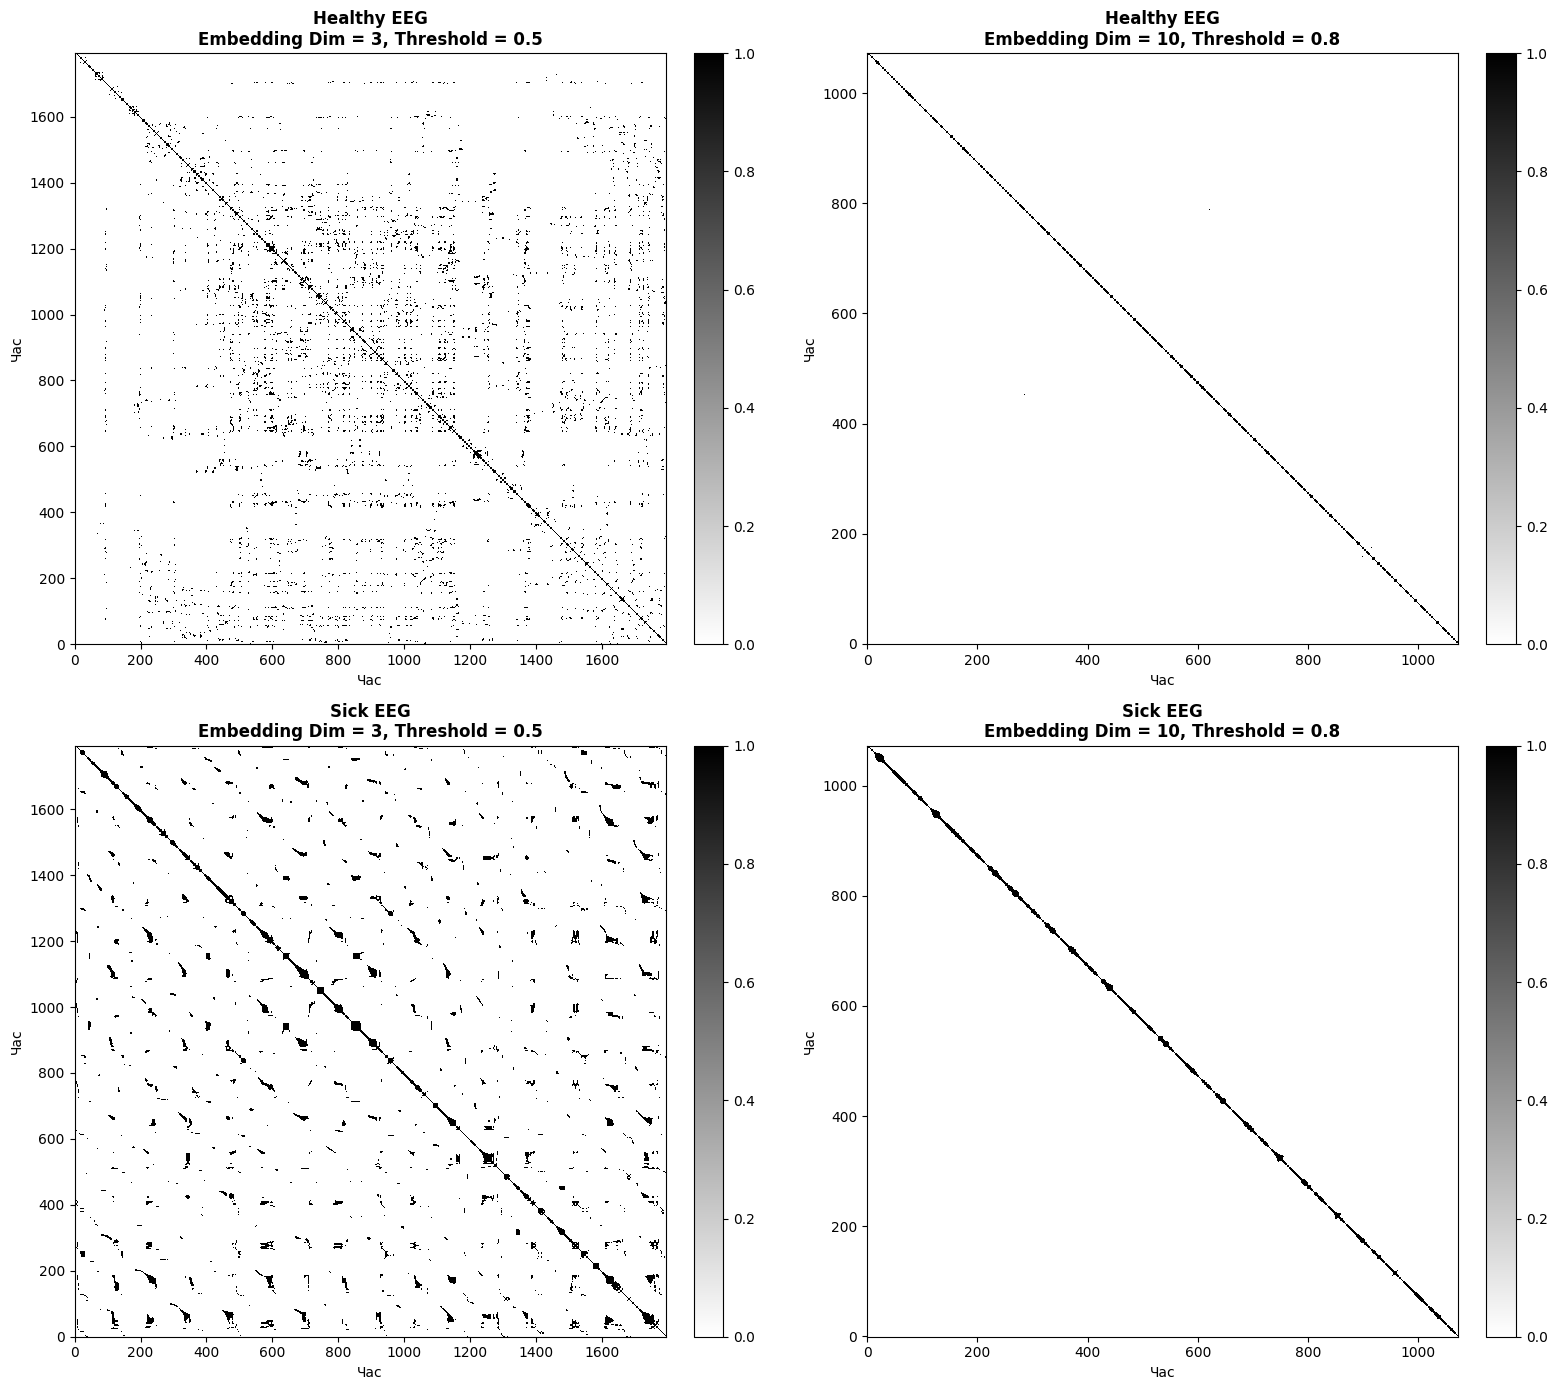

In [69]:

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.flatten()

plot_idx = 0
for signal_name in signals_for_rqa.keys():
    for emb_dim in embedding_dimensions:
        ax = axes[plot_idx]
        
        rec_matrix = results[signal_name][emb_dim]['recurrence_matrix']
        threshold = results[signal_name][emb_dim]['threshold']

        im = ax.imshow(rec_matrix, cmap='binary', origin='lower', interpolation='nearest')
        ax.set_title(f'{signal_name}\nEmbedding Dim = {emb_dim}, Threshold = {threshold}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Час')
        ax.set_ylabel('Час')

        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        
        plot_idx += 1

plt.tight_layout()
plt.show()

In [70]:

table_data = []

for signal_name in signals_for_rqa.keys():
    for emb_dim in embedding_dimensions:
        metrics = results[signal_name][emb_dim]['metrics']
        threshold = results[signal_name][emb_dim]['threshold']
        
        row = {
            'Сигнал': signal_name,
            'Embedding Dim (n)': emb_dim,
            'Delay (τ)': time_delay,
            'Threshold': threshold,
            'RR (%)': f"{metrics['Recurrence Rate (RR)'] * 100:.2f}",
            'DET (%)': f"{metrics['Determinism (DET)'] * 100:.2f}",
            'Lmax': metrics['Lmax'],
            'Entropy': f"{metrics['Entropy']:.4f}",
            'LAM (%)': f"{metrics['Laminarity (LAM)'] * 100:.2f}",
            'TT': f"{metrics['Trapping Time (TT)']:.2f}"
        }
        table_data.append(row)

df_results = pd.DataFrame(table_data)
df_results

,Сигнал,Embedding Dim (n),Delay (τ),Threshold,RR (%),DET (%),Lmax,Entropy,LAM (%),TT
0,Healthy EEG,3,103,0.5,2.49,79.52,170,1.3993,90.32,3.89
1,Healthy EEG,10,103,0.8,0.39,94.71,338,1.7558,99.73,4.16
2,Sick EEG,3,103,0.5,3.19,98.01,1793,2.5296,99.08,7.97
3,Sick EEG,10,103,0.8,0.68,99.02,1072,2.9917,99.99,7.23


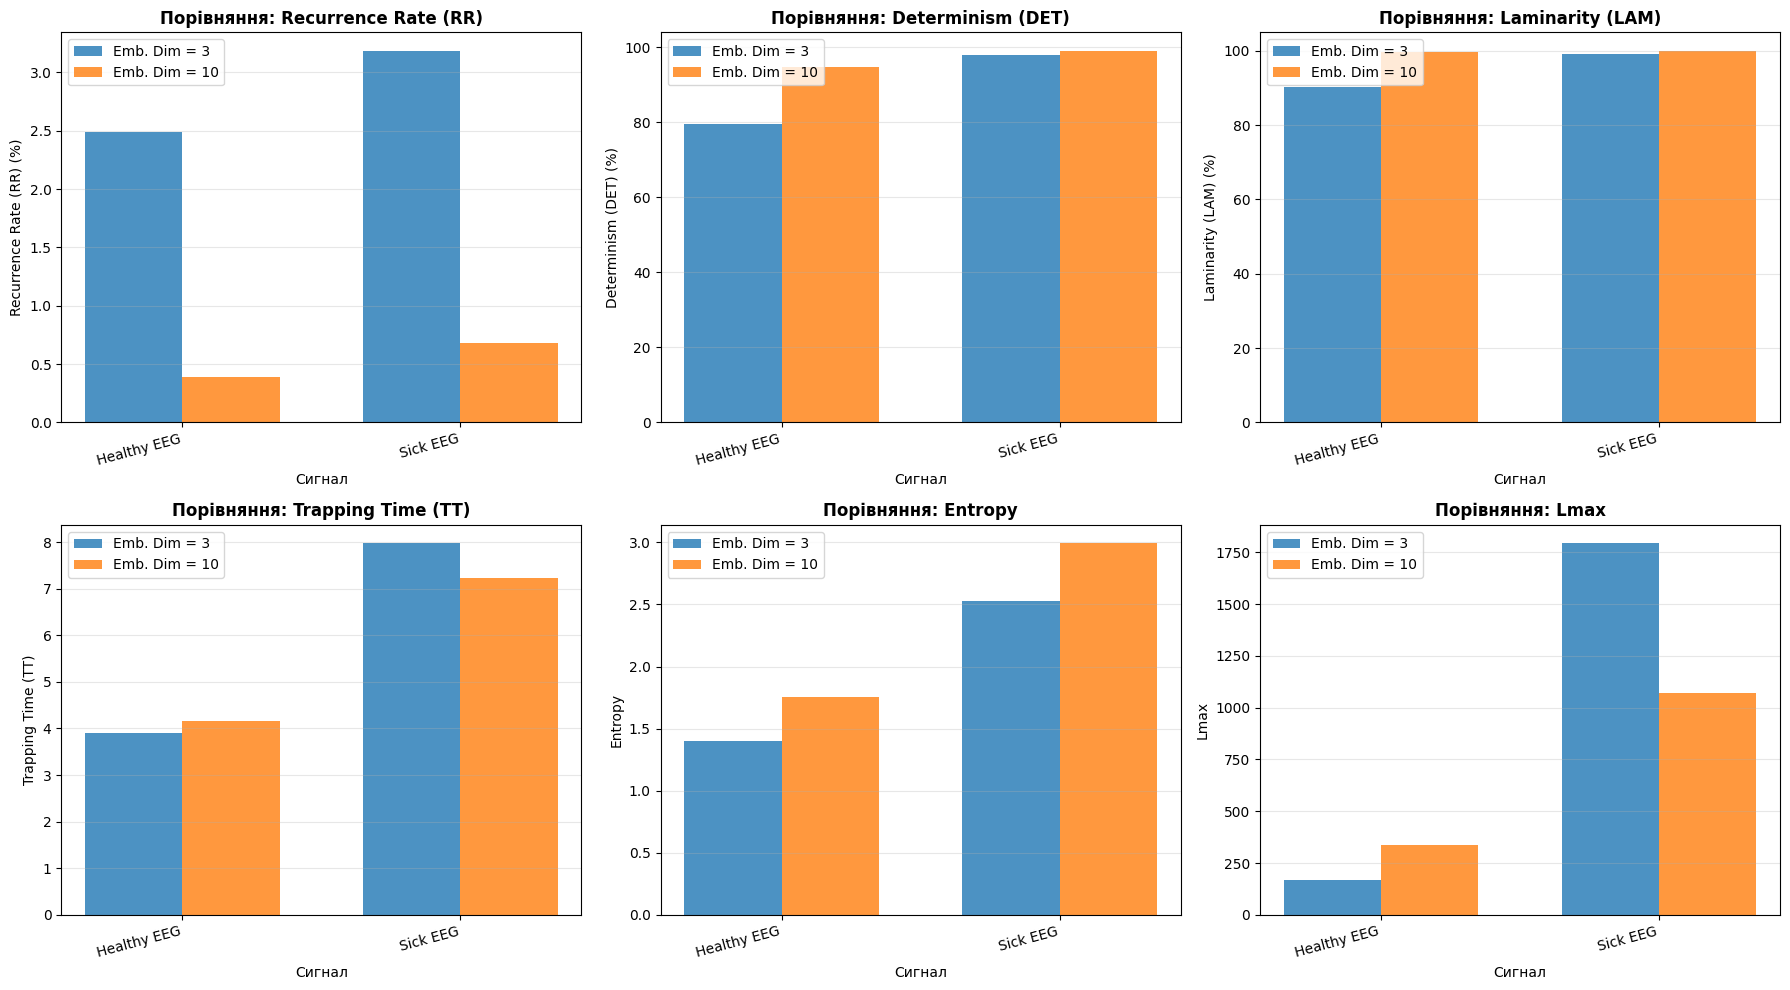

In [71]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics_names = ['Recurrence Rate (RR)', 'Determinism (DET)', 'Laminarity (LAM)', 
                 'Trapping Time (TT)', 'Entropy', 'Lmax']

for idx, metric_name in enumerate(metrics_names):
    ax = axes[idx]
    
    x_pos = np.arange(len(signals_for_rqa))
    width = 0.35
    
    values_dim3 = [results[signal][3]['metrics'][metric_name] for signal in signals_for_rqa.keys()]
    values_dim10 = [results[signal][10]['metrics'][metric_name] for signal in signals_for_rqa.keys()]

    if metric_name in ['Recurrence Rate (RR)', 'Determinism (DET)', 'Laminarity (LAM)']:
        values_dim3 = [v * 100 for v in values_dim3]
        values_dim10 = [v * 100 for v in values_dim10]
    
    ax.bar(x_pos - width/2, values_dim3, width, label='Emb. Dim = 3', alpha=0.8)
    ax.bar(x_pos + width/2, values_dim10, width, label='Emb. Dim = 10', alpha=0.8)
    
    ax.set_xlabel('Сигнал')
    
    if metric_name in ['Recurrence Rate (RR)', 'Determinism (DET)', 'Laminarity (LAM)']:
        ax.set_ylabel(f'{metric_name} (%)')
    else:
        ax.set_ylabel(metric_name)
    
    ax.set_title(f'Порівняння: {metric_name}', fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(list(signals_for_rqa.keys()), rotation=15, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## Завдання 5

### Завдання 5.1: Підготовка сигналів для DFA

In [74]:
import nolds
from scipy.signal import detrend

signals_for_dfa = {
    'Healthy EEG': healthy[:10000],
    'Sick EEG': sick[:10000],
}


def prepare_signal_for_dfa(signal):
    signal_detrended = detrend(signal, type='linear')
    signal_normalized = (signal_detrended - np.mean(signal_detrended)) / np.std(signal_detrended)
    return signal_normalized

prepared_signals = {}
for name, signal in signals_for_dfa.items():
    prepared_signals[name] = prepare_signal_for_dfa(signal)
    print(f"{name}:")
    print(f"before: Mean: {np.mean(signal):.4f}, Std: {np.std(signal):.4f}")
    print(f"after: Mean: {np.mean(prepared_signals[name]):.10f}, Std: {np.std(prepared_signals[name]):.4f}")
    print()

Healthy EEG:
before: Mean: 0.3977, Std: 8.4850
after: Mean: -0.0000000000, Std: 1.0000

Sick EEG:
before: Mean: 24.4631, Std: 354.3294
after: Mean: -0.0000000000, Std: 1.0000



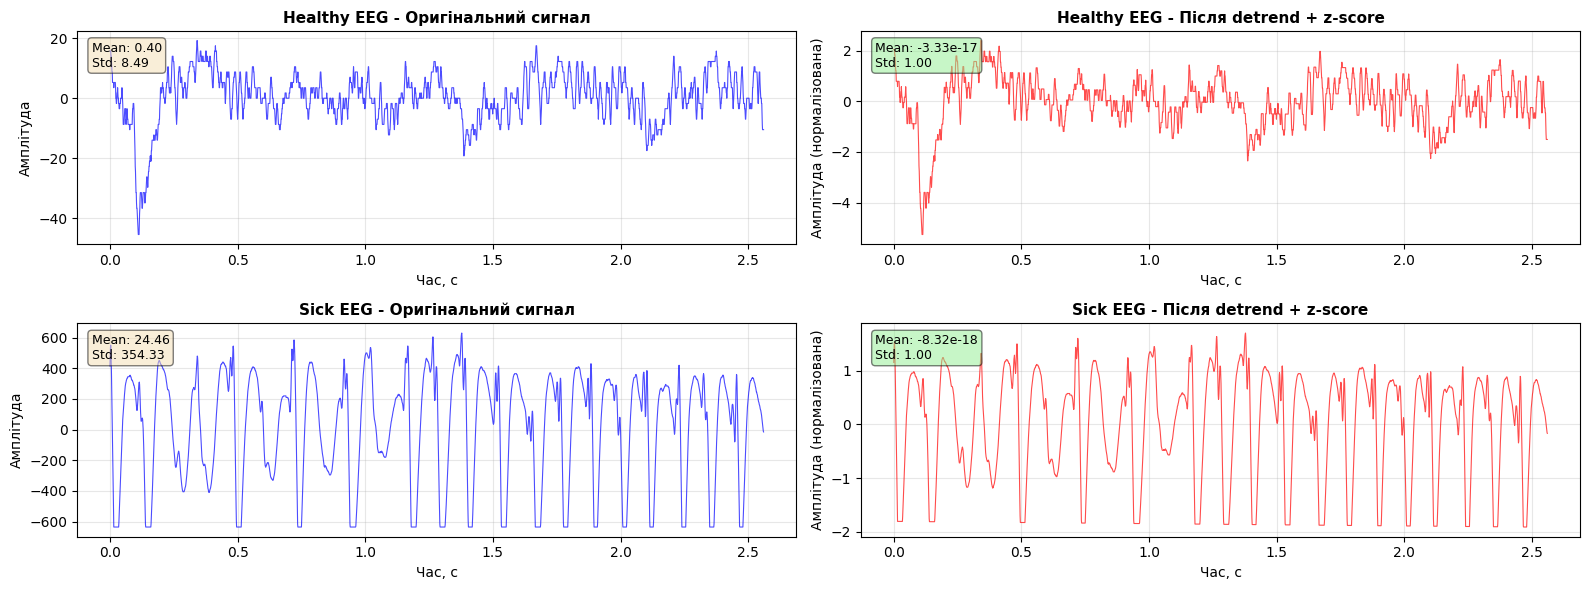

In [75]:
fig, axes = plt.subplots(len(signals_for_dfa), 2, figsize=(16, 3*len(signals_for_dfa)))

for idx, (name, original_signal) in enumerate(signals_for_dfa.items()):
    prepared_signal = prepared_signals[name]

    ax1 = axes[idx, 0]
    t_axis = np.arange(len(original_signal)) / fs if 'EEG' in name else np.arange(len(original_signal)) / acc_fs
    ax1.plot(t_axis, original_signal, 'b-', linewidth=0.8, alpha=0.7)
    ax1.set_title(f'{name} - Оригінальний сигнал', fontsize=11, fontweight='bold')
    ax1.set_xlabel('Час, с')
    ax1.set_ylabel('Амплітуда')
    ax1.grid(True, alpha=0.3)
    ax1.text(0.02, 0.95, f'Mean: {np.mean(original_signal):.2f}\nStd: {np.std(original_signal):.2f}',
             transform=ax1.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax2 = axes[idx, 1]
    ax2.plot(t_axis, prepared_signal, 'r-', linewidth=0.8, alpha=0.7)
    ax2.set_title(f'{name} - Після detrend + z-score', fontsize=11, fontweight='bold')
    ax2.set_xlabel('Час, с')
    ax2.set_ylabel('Амплітуда (нормалізована)')
    ax2.grid(True, alpha=0.3)
    ax2.text(0.02, 0.95, f'Mean: {np.mean(prepared_signal):.2e}\nStd: {np.std(prepared_signal):.2f}',
             transform=ax2.transAxes, fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

plt.tight_layout()
plt.show()

### Завдання 5.2

In [83]:
dfa_results = {}
for name, signal in prepared_signals.items():
    alpha = nolds.dfa(signal, nvals=None, overlap=True, order=1, fit_trend='poly', 
                        fit_exp='RANSAC', debug_plot=False, plot_file=None)
    dfa_results[name] = alpha
    print(f"  alpha = {alpha:.4f}")

  alpha = 1.3232
  alpha = 1.5210
  alpha = 1.5210


In [86]:

dfa_table_data = []

for name, alpha in dfa_results.items():
    row = {
        'Сигнал': name,
        'alpha (DFA)': f"{alpha:.4f}",
    }
    dfa_table_data.append(row)

df_dfa = pd.DataFrame(dfa_table_data)
df_dfa

,Сигнал,alpha (DFA)
0,Healthy EEG,1.3232
1,Sick EEG,1.5210
